In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
raw = pd.read_excel(r"/content/NHB_Residex.xlsx",'Sheet2')
raw['Quarter'] = pd.to_datetime(raw['Quarter']);                                                                                                                                                                    np.random.seed(107)
raw.set_index('Quarter', inplace=True)
import warnings
warnings.filterwarnings("ignore")
analysis_df = pd.DataFrame(columns=['City','Size','Model', 'RMSE', 'MAE', 'MAPE'])

#   City-Ahmedabad
*   Status-Ready-to-move
*   Data-NHB-Quaterly-2013-2023

In [ ]:
df_raw = raw[(raw.City=='Ahmedabad') & (raw.status=='Ready to move')]
df_raw.drop(['City', 'status'],axis=1, inplace=True)
df_raw.sort_values(by=['Quarter'],ascending=True,inplace=True)
# df_raw['Composite Price'] = df_raw['Composite Price'].apply(lambda x:str(x).replace('-','1'))
# df_raw['Composite Price'] = df_raw['Composite Price'].astype(float)
df_raw.head()

Record Count  Composite Index Composite Price  small  medium  \
Quarter                                                                    
2013-06-01           832             92.0               -   2820    3178   
2013-09-01           999             92.0               -   3041    3120   
2013-12-01          1087             87.0               -   2945    2865   
2014-03-01          1361             86.0               -   2880    2840   
2014-06-01          1335             92.0               -   3120    3000   

            large  
Quarter            
2013-06-01   4003  
2013-09-01   3827  
2013-12-01   3893  
2014-03-01   3840  
2014-06-01   4080

In [ ]:
# Split the data into train and test sets
split_point = int(len(df_raw) * 0.8)  # 80% for training
train, test = df_raw[0:split_point], df_raw[split_point:]
print(df_raw.shape,train.shape,test.shape)

(43, 6) (34, 6) (9, 6)


In [ ]:
df_raw.tail()

Record Count  Composite Index Composite Price  small  medium  \
Quarter                                                                    
2022-12-01          8846            192.0            6764   6175    7054   
2023-03-01         11199            190.0            6695   6195    6857   
2023-06-01          9222            195.0            6859   6382    6954   
2023-09-01         11312            199.0            7009   6546    7253   
2023-12-01          9310            206.0            7238   6414    7650   

            large  
Quarter            
2022-12-01   7087  
2023-03-01   7200  
2023-06-01   7500  
2023-09-01   7219  
2023-12-01   7673

## Univariate-Exp Smoothing

###Small

Best parameters: (0.2, 0.2, 0.2, 'add', 'add')


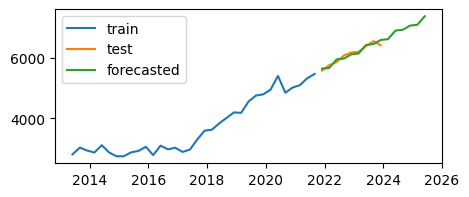

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['small'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    rmse = sqrt(mean_squared_error(test['small'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['small'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['small'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['small'], predictions)
mape = mean_absolute_percentage_error(test['small'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Small'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['small'], label='train')
plt.plot(test.index,test['small'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_small = pd.concat([test[['small']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small[0],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

### Medium

Best parameters: (1.0, 0.0, 0.6, 'add', 'add')
Lowest RMSE: 247.21633901085252
Test RMSE: 247.216


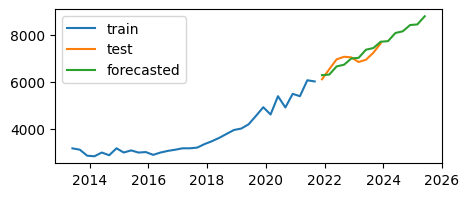

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['medium'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['medium'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['medium'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['medium'], predictions)
mape = mean_absolute_percentage_error(test['medium'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Medium'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['medium'], label='train')
plt.plot(test.index,test['medium'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_medium = pd.concat([test[['medium']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium[0],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

###Large

Best parameters: (0.8, 0.0, 0.4, 'add', 'add')
Lowest RMSE: 337.97698329568146
Test RMSE: 337.977


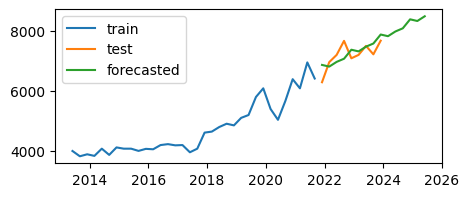

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['large'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    rmse = sqrt(mean_squared_error(test['large'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['large'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['large'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['large'], predictions)
mape = mean_absolute_percentage_error(test['large'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Large'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['large'], label='train')
plt.plot(test.index,test['large'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_large = pd.concat([test[['large']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large[0],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

### Index

Best parameters: (1.0, 0.0, 0.4, 'add', 'add')
Lowest RMSE: 4.804731078576473
Test RMSE: 4.805


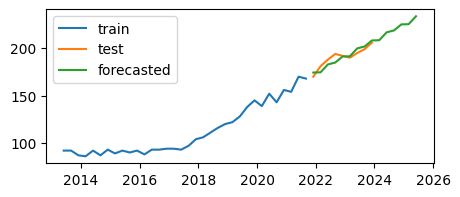

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['Composite Index'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    rmse = sqrt(mean_squared_error(test['Composite Index'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['Composite Index'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['Composite Index'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['Composite Index'], predictions)
mape = mean_absolute_percentage_error(test['Composite Index'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Index'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['Composite Index'], label='train')
plt.plot(test.index,test['Composite Index'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_Index = pd.concat([test[['Composite Index']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Index['Composite Index'] = np.where(test_Index['Composite Index'].isna(),test_Index[0],test_Index['Composite Index'])
test_Index = test_Index[['Composite Index']]
plt.plot(test_Index.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

###composite price

In [ ]:
df_raw = df_raw[df_raw['Composite Price']!='-']
df_raw['Composite Price'] = df_raw['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df_raw) * 0.8)  # 80% for training
train, test = df_raw[0:split_point], df_raw[split_point:]
df_raw.shape

(23, 6)

Best parameters: (0.0, 0.0, 0.2, 'mul', 'add')
Lowest RMSE: 104.83654655454878
Test RMSE: 104.837


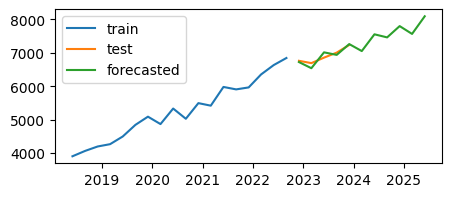

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['Composite Price'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    rmse = sqrt(mean_squared_error(test['Composite Price'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['Composite Price'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['Composite Price'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['Composite Price'], predictions)
mape = mean_absolute_percentage_error(test['Composite Price'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Composite Price'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['Composite Price'], label='train')
plt.plot(test.index,test['Composite Price'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_Price = pd.concat([test[['Composite Price']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Price['Composite Price'] = np.where(test_Price['Composite Price'].isna(),test_Price[0],test_Price['Composite Price'])
test_Price = test_Price[['Composite Price']]
plt.plot(test_Price.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

##Univariate_Arima

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.1 MB/s eta 0:00:00


###small

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.21 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=66.432, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=70.203, Time=1.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=66.781, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=66.649, Time=0.15 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=68.191, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 6.668 seconds
Test RMSE: 232.98111511450878


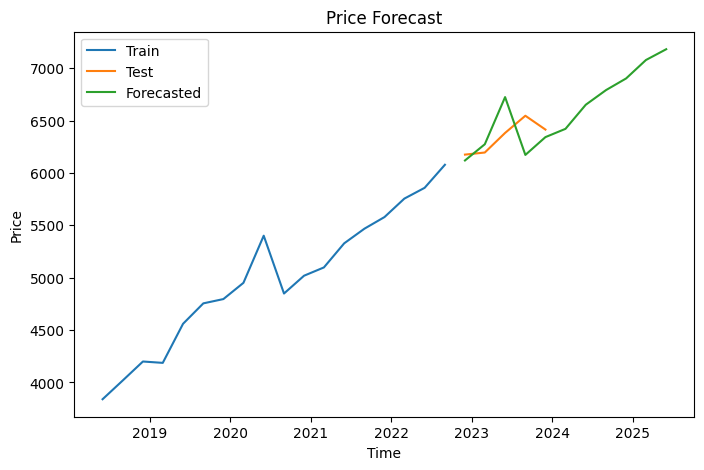

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['small'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['small'])

# Make predictions
forecast = model.predict(n_periods=len(test['small']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], forecast)
mape = mean_absolute_percentage_error(test['small'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Small'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
# plt.plot(test.index, forecast, label='Forecast')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['small'])+6)
test_small = pd.concat([test[['small']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small[0],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

###medium

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2890361598.168, Time=0.71 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=71.385, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=75.253, Time=0.75 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=73.267, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=71.686, Time=0.18 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2890361631.207, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=73.370, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 3.793 seconds
Test RMSE: 518.3558623185427


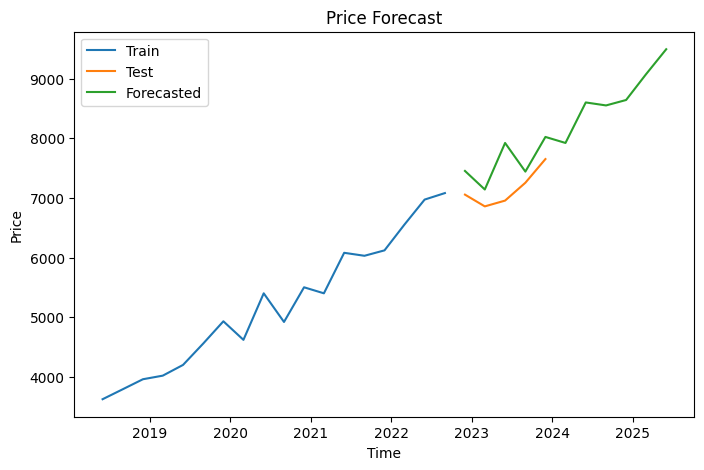

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['medium'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['medium'])

# Make predictions
forecast = model.predict(n_periods=len(test['medium']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], forecast)
mape = mean_absolute_percentage_error(test['medium'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Medium'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['medium'])+6)
test_medium = pd.concat([test[['medium']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium[0],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### large

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=40721993075.356, Time=0.43 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=74.966, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=76.952, Time=0.58 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=76.953, Time=0.18 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=78.953, Time=0.47 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=75.916, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=40721993073.356, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=76.839, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 4.563 seconds
Test RMSE: 557.2816164202799


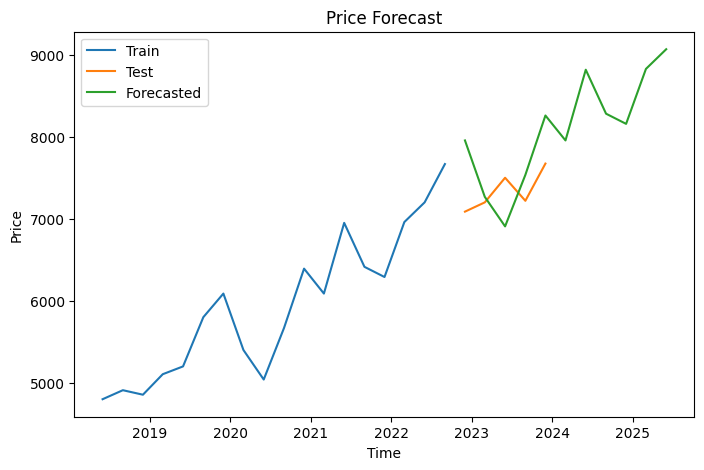

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['large'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['large'])

# Make predictions
forecast = model.predict(n_periods=len(test['large']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], forecast)
mape = mean_absolute_percentage_error(test['large'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Large'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['large'])+6)
test_large = pd.concat([test[['large']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large[0],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### Index

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=998383.744, Time=0.59 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=33.229, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=37.228, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=36.624, Time=0.31 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=35.229, Time=0.13 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=35.229, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=37.229, Time=0.51 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=35.228, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=34.624, Time=0.16 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=998381.744, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=35.169, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 2.911 seconds
Test RMSE: 7.886697661246814


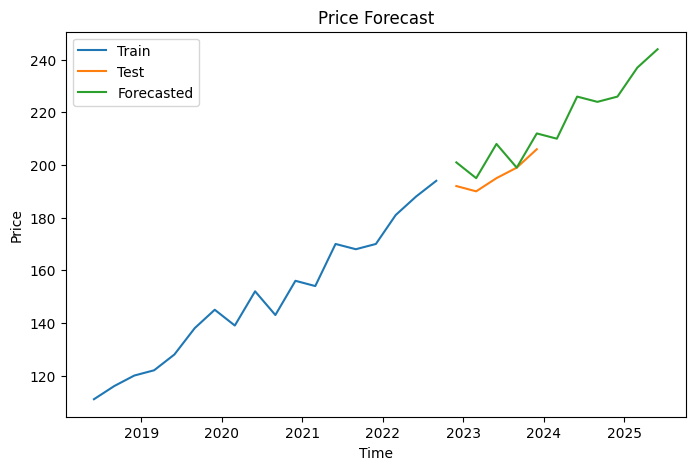

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['Composite Index'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['Composite Index'])

# Make predictions
forecast = model.predict(n_periods=len(test['Composite Index']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Index'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Index'], forecast)
mape = mean_absolute_percentage_error(test['Composite Index'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Index'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Index'], label='Train')
plt.plot(test.index, test['Composite Index'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['Composite Index'])+6)
test_Index = pd.concat([test[['Composite Index']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Index['Composite Index'] = np.where(test_Index['Composite Index'].isna(),test_Index[0],test_Index['Composite Index'])
test_Index = test_Index[['Composite Index']]
plt.plot(test_Index.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### composite price

In [ ]:
df = df_raw[df_raw['Composite Price']!='-']
df['Composite Price'] = df['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df) * 0.8)  # 80% for training
train, test = df[0:split_point], df[split_point:]
df.shape

(23, 6)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1211121399.892, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=68.734, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=72.622, Time=0.93 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=70.621, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=70.095, Time=0.15 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1211121397.892, Time=0.21 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=70.704, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 4.452 seconds
Test RMSE: 294.8854014697913


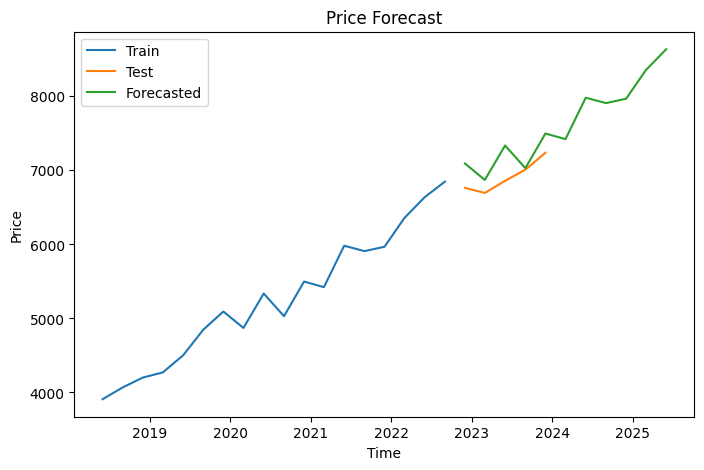

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['Composite Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['Composite Price'])

# Make predictions
forecast = model.predict(n_periods=len(test['Composite Price']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Price'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Price'], forecast)
mape = mean_absolute_percentage_error(test['Composite Price'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Composite Price'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Price'], label='Train')
plt.plot(test.index, test['Composite Price'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['Composite Price'])+6)
test_Price = pd.concat([test[['Composite Price']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Price['Composite Price'] = np.where(test_Price['Composite Price'].isna(),test_Price[0],test_Price['Composite Price'])
test_Price = test_Price[['Composite Price']]
plt.plot(test_Price.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

##ML-Model

In [ ]:
!pip install keras tensorflow

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

###Small

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['small']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['small'].tail(6).min()
max_price = df['small'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['small'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Small'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 10s 7ms/step - loss: 0.3352
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 0.2191
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0931
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0300
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0242
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0219
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0183
Epoch 9/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0144
Epoch 10/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0114
Epoch 11/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 12/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 13/100
22/22 [================

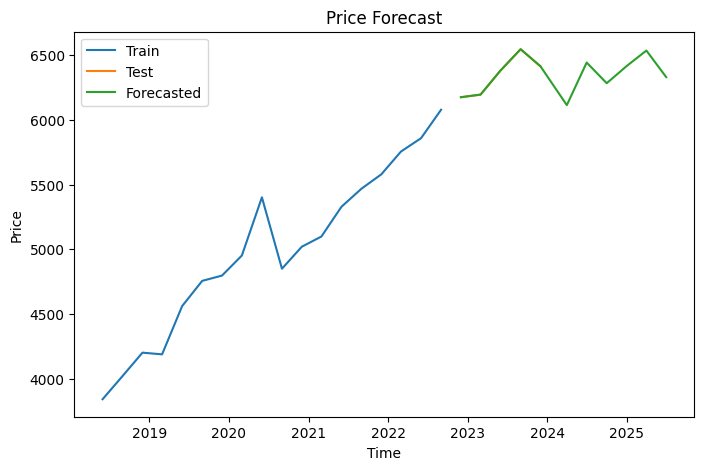

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['small']], forecast_df], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,test_small['small'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Medium

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['medium']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['medium'].tail(6).min()
max_price = df['medium'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['medium'], forecast_df[:5]) * 100
# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Medium'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 6s 6ms/step - loss: 0.3164
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.2152
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1074
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0411
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0326
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0284
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 8/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0194
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0163
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0136
Epoch 11/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0107
Epoch 12/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0098
Epoch 13/100
22/22 [=================

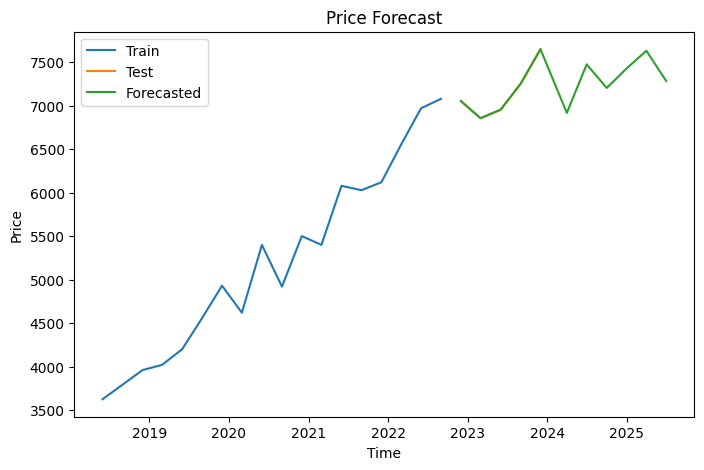

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_medium = pd.concat([test[['medium']], forecast_df], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium['Forecasted Price'],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,test_medium['medium'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###large

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['large']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['large'].tail(6).min()
max_price = df['large'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['large'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Large'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 9s 6ms/step - loss: 0.3357
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2340
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.1258
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0574
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0437
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 7/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0369
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0341
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0326
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0312
Epoch 11/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0289
Epoch 12/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 13/100
22/22 [================

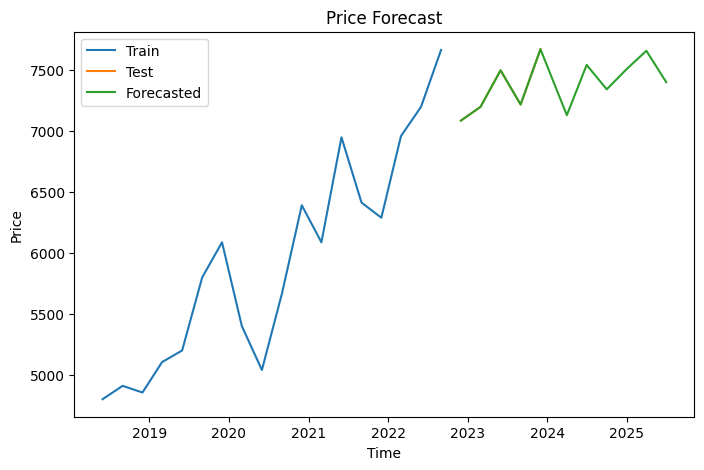

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_large = pd.concat([test[['large']], forecast_df], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large['Forecasted Price'],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,test_large['large'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Index

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['Composite Index']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['Composite Index'].tail(6).min()
max_price = df['Composite Index'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Index'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Index'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['Composite Index'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Index'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 7s 9ms/step - loss: 0.3293
Epoch 2/100
22/22 [==============================] - 0s 10ms/step - loss: 0.2173
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0888
Epoch 4/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0345
Epoch 5/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0295
Epoch 6/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0245
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0213
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0140
Epoch 10/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0113
Epoch 11/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0098
Epoch 12/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0076
Epoch 13/100
22/22 [==============

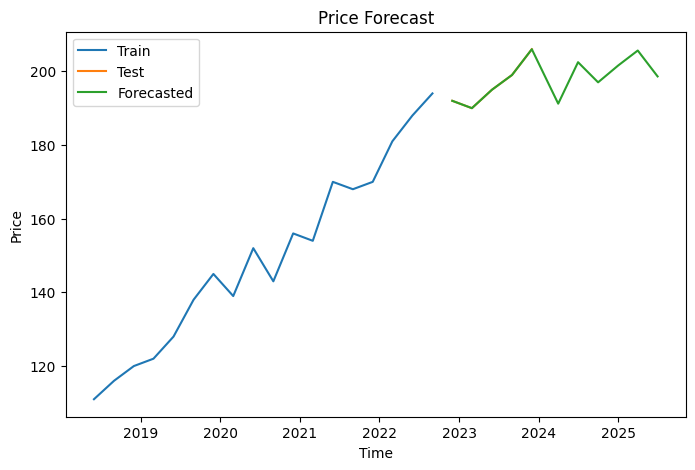

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Index'], label='Train')
plt.plot(test.index, test['Composite Index'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_index = pd.concat([test[['Composite Index']], forecast_df], ignore_index=False)
test_index['Composite Index'] = np.where(test_index['Composite Index'].isna(),test_index['Forecasted Price'],test_index['Composite Index'])
test_index = test_index[['Composite Index']]
plt.plot(test_index.index,test_index['Composite Index'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Composite Price

In [ ]:
df = df_raw[df_raw['Composite Price']!='-']
df['Composite Price'] = df['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df) * 0.8)  # 80% for training
train, test = df[0:split_point], df[split_point:]
df.shape

(23, 6)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df[['Composite Price']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['Composite Price'].tail(6).min()
max_price = df['Composite Price'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Price'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')
mae = mean_absolute_error(test['Composite Price'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['Composite Price'], forecast_df[:5]) * 100
# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Composite Price'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 6s 9ms/step - loss: 0.3310
Epoch 2/100
22/22 [==============================] - 0s 9ms/step - loss: 0.2299
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 0.1135
Epoch 4/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0406
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0306
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0246
Epoch 7/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0213
Epoch 8/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0178
Epoch 9/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0151
Epoch 10/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 11/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 12/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 13/100
22/22 [================

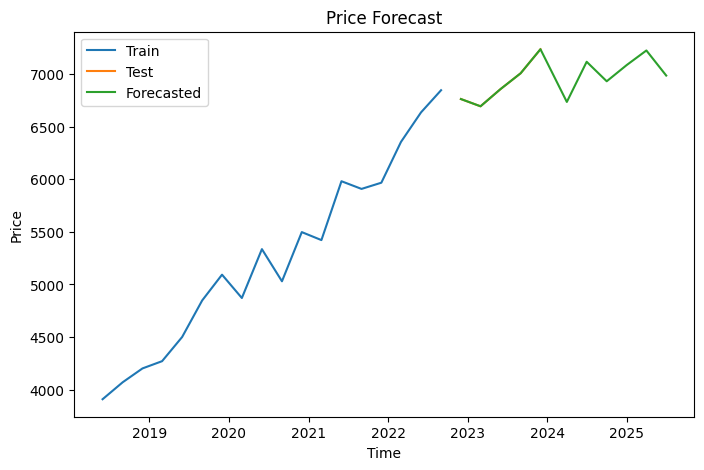

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Price'], label='Train')
plt.plot(test.index, test['Composite Price'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_price = pd.concat([test[['Composite Price']], forecast_df], ignore_index=False)
test_price['Composite Price'] = np.where(test_price['Composite Price'].isna(),test_price['Forecasted Price'],test_price['Composite Price'])
test_price = test_price[['Composite Price']]
plt.plot(test_price.index,test_price['Composite Price'], label='Forecasted')

plt.legend(loc='best')
plt.show()

##Time-GPT

###small

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['small']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00


False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='small').rename(columns={'TimeGPT':'small'})
forecast_df.tail(2)

Quarter        small
13  2026-02-28  7210.608398
14  2026-05-31  7391.666992

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['small']

Quarter
2022-12-01    6175
2023-03-01    6195
2023-06-01    6382
2023-09-01    6546
2023-12-01    6414
Name: small, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], f['small'][:5]))
print(f'Test RMSE: {rmse}')
mae = mean_absolute_error(test['small'], f['small'][:5])
mape = mean_absolute_percentage_error(test['small'], f['small'][:5]) * 100
# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Small'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 186.1734321262107


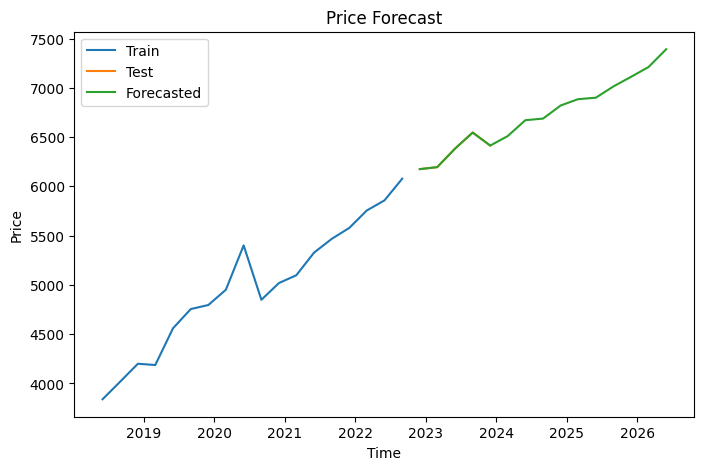

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['small']], f[['small']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,test_small['small'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Medium

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['medium']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='medium').rename(columns={'TimeGPT':'medium'})
forecast_df.tail(2)

Quarter       medium
13  2026-02-28  9092.619141
14  2026-05-31  9382.550781

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['medium']

Quarter
2022-12-01    7054
2023-03-01    6857
2023-06-01    6954
2023-09-01    7253
2023-12-01    7650
Name: medium, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], f['medium'][:5]))
print(f'Test RMSE: {rmse}')
mae = mean_absolute_error(test['medium'], f['medium'][:5])
mape = mean_absolute_percentage_error(test['medium'], f['medium'][:5]) * 100
# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Medium'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 688.1903626456296


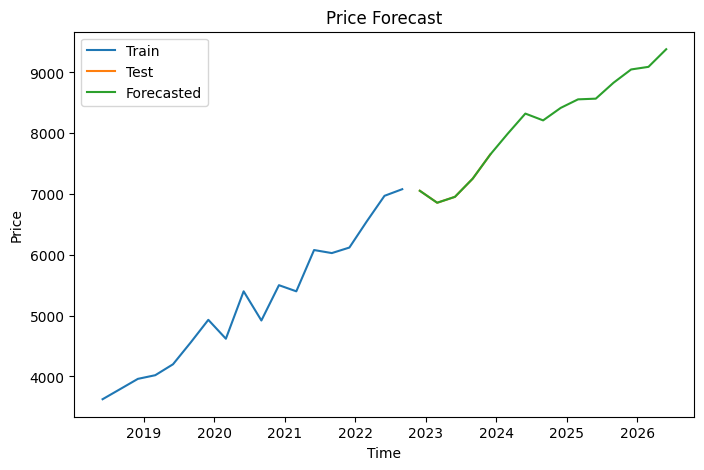

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['medium']], f[['medium']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['medium']]
plt.plot(test_small.index,test_small['medium'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Large

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['large']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='large').rename(columns={'TimeGPT':'large'})
forecast_df.tail(2)

Quarter        large
13  2026-02-28  8515.976562
14  2026-05-31  8454.800781

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['large']

Quarter
2022-12-01    7087
2023-03-01    7200
2023-06-01    7500
2023-09-01    7219
2023-12-01    7673
Name: large, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], f['large'][:5]))
print(f'Test RMSE: {rmse}')
mae = mean_absolute_error(test['large'], f['large'][:5])
mape = mean_absolute_percentage_error(test['large'], f['large'][:5]) * 100
# Report df
data = pd.DataFrame({'City':['Ahmedabad'], 'Size':['Large'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 499.1547323448052


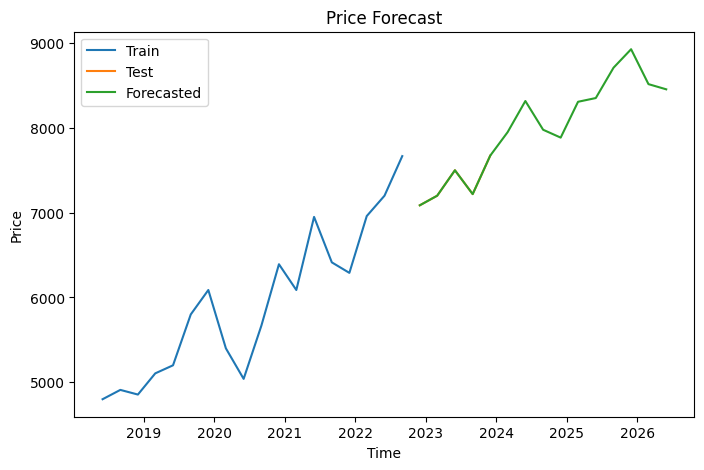

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['large']], f[['large']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['large']]
plt.plot(test_small.index,test_small['large'], label='Forecasted')

plt.legend(loc='best')
plt.show()

#   City-Mumbai
*   Status-Ready-to-move
*   Data-NHB-Quaterly-2013-2023

In [ ]:
df_raw = raw[(raw.City=='Mumbai') & (raw.status=='Ready to move')]
df_raw.drop(['City', 'status'],axis=1, inplace=True)
df_raw.sort_values(by=['Quarter'],ascending=True,inplace=True)

In [ ]:
# Split the data into train and test sets
split_point = int(len(df_raw) * 0.8)  # 80% for training
train, test = df_raw[0:split_point], df_raw[split_point:]
df_raw.shape

(43, 6)

In [ ]:
df_raw.tail()

Record Count  Composite Index Composite Price  small  medium  \
Quarter                                                                    
2022-12-01          7181            110.0           24866  22811   25843   
2023-03-01          9724            110.0           24996  23016   26173   
2023-06-01          8358            112.0           25371  23352   26587   
2023-09-01         10139            115.0           26032  23674   27555   
2023-12-01         11142            113.0           25472  22673   27264   

            large  
Quarter            
2022-12-01  32453  
2023-03-01  31511  
2023-06-01  31953  
2023-09-01  33376  
2023-12-01  34248

## Univariate-Exp Smoothing

###Small

In [ ]:
analysis_df.head(2)

City    Size                     Model        RMSE         MAE  \
0  Ahmedabad   Small  Univariate_Exp_Smoothing   92.312396   84.659730   
1  Ahmedabad  Medium  Univariate_Exp_Smoothing  247.216339  218.375268   

       MAPE  
0  1.381887  
1  3.169865

Best parameters: (1.0, 0.0, 0.2, 'mul', 'mul')
Lowest RMSE: 303.48581489039327
Test RMSE: 303.486


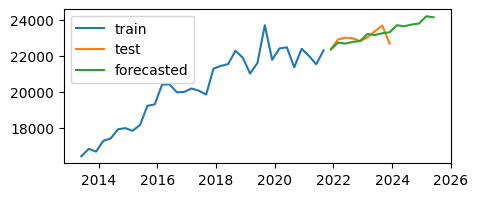

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['small'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    rmse = sqrt(mean_squared_error(test['small'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['small'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['small'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['small'], predictions)
mape = mean_absolute_percentage_error(test['small'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Small'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['small'], label='train')
plt.plot(test.index,test['small'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_small = pd.concat([test[['small']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small[0],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

### Medium

Best parameters: (0.6, 0.0, 0.8, 'mul', 'mul')
Lowest RMSE: 510.80261744494067
Test RMSE: 510.803


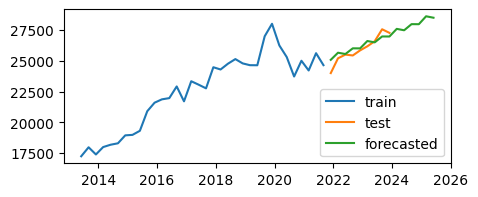

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['medium'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))

                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['medium'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['medium'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['medium'], predictions)
mape = mean_absolute_percentage_error(test['medium'], predictions) * 100
# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Medium'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['medium'], label='train')
plt.plot(test.index,test['medium'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_medium = pd.concat([test[['medium']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium[0],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

###Large

Best parameters: (0.8, 0.0, 0.6, 'mul', 'mul')
Lowest RMSE: 519.9813172296209
Test RMSE: 519.981


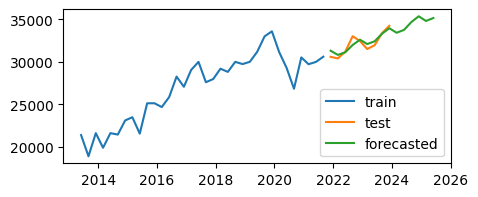

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['large'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['large'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['large'].min()
                      max_price = test['large'].max()
                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['large']))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['large'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['large'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['large'], predictions)
mape = mean_absolute_percentage_error(test['large'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Large'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['large'], label='train')
plt.plot(test.index,test['large'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_large = pd.concat([test[['large']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large[0],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

### Index

Best parameters: (0.8, 0.0, 0.0, 'add', 'add')
Lowest RMSE: 1.1234850870246718
Test RMSE: 1.123


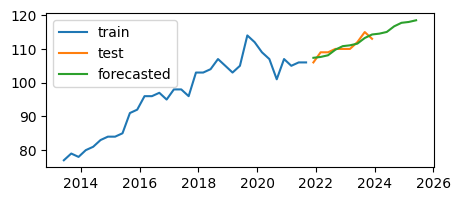

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['Composite Index'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    rmse = sqrt(mean_squared_error(test['Composite Index'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['Composite Index'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['Composite Index'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['Composite Index'], predictions)
mape = mean_absolute_percentage_error(test['Composite Index'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Index'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['Composite Index'], label='train')
plt.plot(test.index,test['Composite Index'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_Index = pd.concat([test[['Composite Index']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Index['Composite Index'] = np.where(test_Index['Composite Index'].isna(),test_Index[0],test_Index['Composite Index'])
test_Index = test_Index[['Composite Index']]
plt.plot(test_Index.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

###composite price

In [ ]:
df_raw = df_raw[df_raw['Composite Price']!='-']
df_raw['Composite Price'] = df_raw['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df_raw) * 0.8)  # 80% for training
train, test = df_raw[0:split_point], df_raw[split_point:]
df_raw.shape

(23, 6)

Best parameters: (0.2, 0.8, 1.0, 'add', 'mul')
Lowest RMSE: 189.016462764612
Test RMSE: 189.016


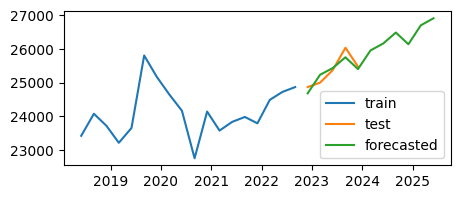

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['Composite Price'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    rmse = sqrt(mean_squared_error(test['Composite Price'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['Composite Price'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['Composite Price'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['Composite Price'], predictions)
mape = mean_absolute_percentage_error(test['Composite Price'], predictions) * 100
# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Composite Price'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['Composite Price'], label='train')
plt.plot(test.index,test['Composite Price'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_Price = pd.concat([test[['Composite Price']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Price['Composite Price'] = np.where(test_Price['Composite Price'].isna(),test_Price[0],test_Price['Composite Price'])
test_Price = test_Price[['Composite Price']]
plt.plot(test_Price.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

##Univariate_Arima

In [ ]:
!pip install pmdarima

###small

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=86.939, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=84.516, Time=0.59 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=86.515, Time=1.62 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=86.518, Time=1.51 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=2.30 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=2.59 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=86.048, Time=1.91 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=85.922, Time=1.50 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.51 sec
 ARIMA(0,

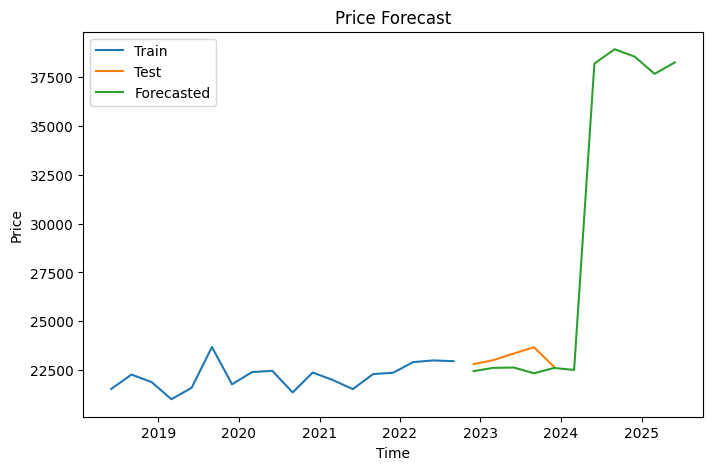

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['small'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['small'])

# Make predictions
forecast = model.predict(n_periods=len(test['small']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], forecast)
mape = mean_absolute_percentage_error(test['small'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Small'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
# plt.plot(test.index, forecast, label='Forecast')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['small'])+6)
test_small = pd.concat([test[['small']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small[0],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

###medium

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=63819811187.013, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=88.568, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=87.119, Time=0.39 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=89.119, Time=1.54 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=1.96 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=87.911, Time=1.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=nan sec
 ARI

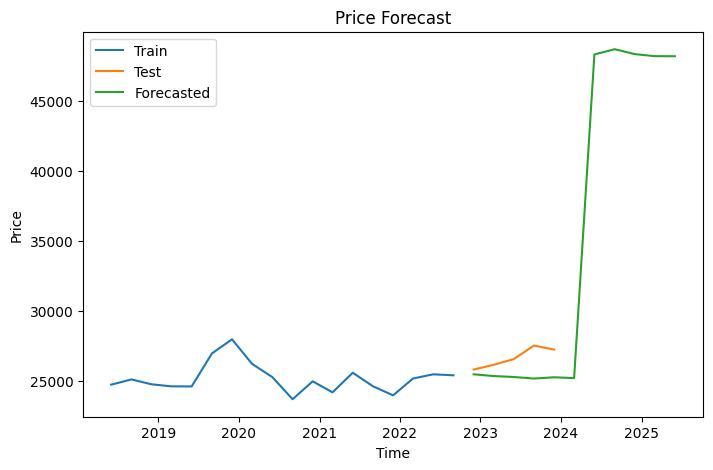

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['medium'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['medium'])

# Make predictions
forecast = model.predict(n_periods=len(test['medium']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], forecast)
mape = mean_absolute_percentage_error(test['medium'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Medium'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['medium'])+6)
test_medium = pd.concat([test[['medium']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium[0],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### large

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4803439879.714, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=75.620, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=77.847, Time=1.01 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=75.444, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=1.61 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=78.428, Time=1.53 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=76.741, Time=0.18 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4803439877.714, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=74.105, Time=0.23 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=75.722, Time=1.72 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=77.

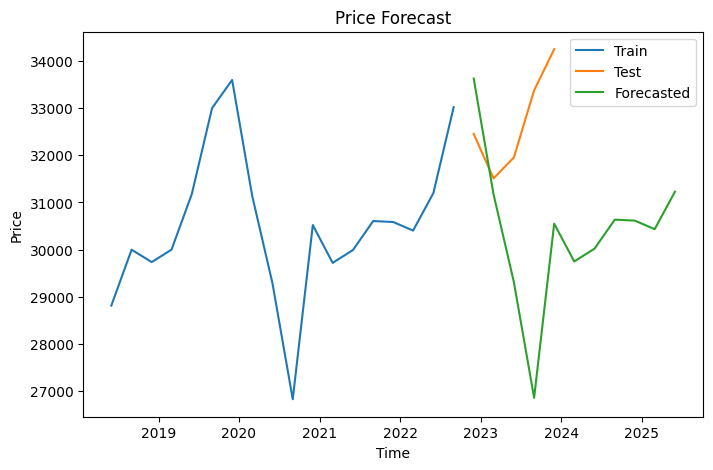

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['large'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['large'])

# Make predictions
forecast = model.predict(n_periods=len(test['large']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], forecast)
mape = mean_absolute_percentage_error(test['large'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Large'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['large'])+6)
test_large = pd.concat([test[['large']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large[0],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### Index

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=700742.389, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=31.459, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=35.371, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=33.459, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=33.459, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=35.459, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=33.371, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=33.108, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.937 seconds
Test RMSE: 10.334408546244182


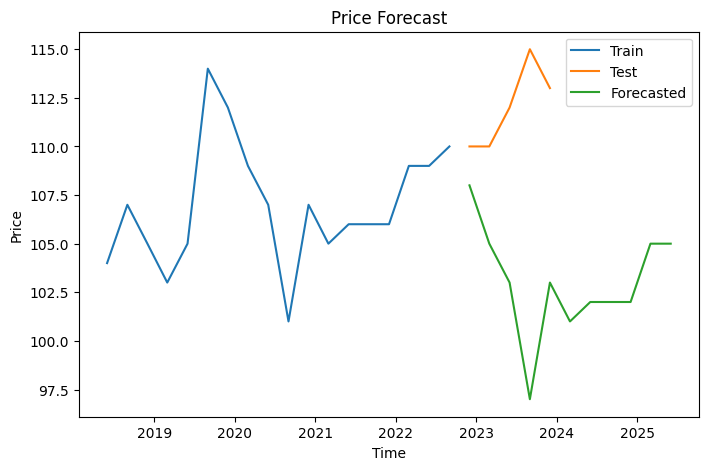

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['Composite Index'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['Composite Index'])

# Make predictions
forecast = model.predict(n_periods=len(test['Composite Index']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Index'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Index'], forecast)
mape = mean_absolute_percentage_error(test['Composite Index'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Index'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Index'], label='Train')
plt.plot(test.index, test['Composite Index'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['Composite Index'])+6)
test_Index = pd.concat([test[['Composite Index']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Index['Composite Index'] = np.where(test_Index['Composite Index'].isna(),test_Index[0],test_Index['Composite Index'])
test_Index = test_Index[['Composite Index']]
plt.plot(test_Index.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### composite price

In [ ]:
df = df_raw[df_raw['Composite Price']!='-']
df['Composite Price'] = df['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df) * 0.8)  # 80% for training
train, test = df[0:split_point], df[split_point:]
df.shape

(23, 6)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=86.021, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=83.889, Time=0.87 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.53 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=85.889, Time=2.10 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=1.40 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.62 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=85.911, Time=0.80 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.21 sec
 ARIMA(0,1,0)(1

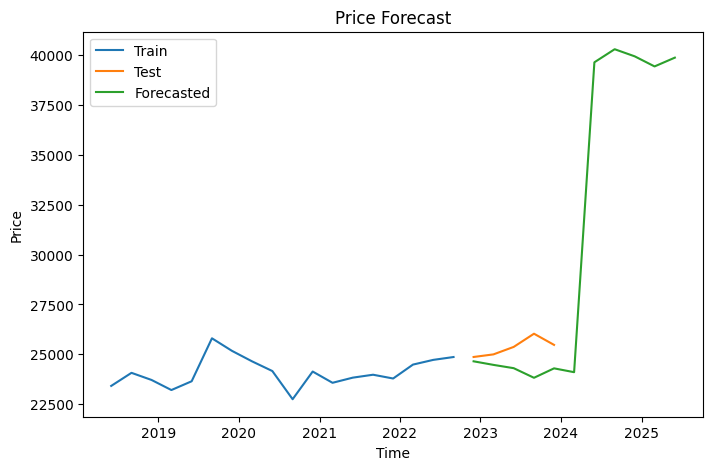

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['Composite Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['Composite Price'])

# Make predictions
forecast = model.predict(n_periods=len(test['Composite Price']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Price'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Price'], forecast)
mape = mean_absolute_percentage_error(test['Composite Price'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Composite Price'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Price'], label='Train')
plt.plot(test.index, test['Composite Price'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['Composite Price'])+6)
test_Price = pd.concat([test[['Composite Price']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Price['Composite Price'] = np.where(test_Price['Composite Price'].isna(),test_Price[0],test_Price['Composite Price'])
test_Price = test_Price[['Composite Price']]
plt.plot(test_Price.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

##ML-Model

In [ ]:
!pip install keras tensorflow

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

###Small

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['small']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['small'].tail(6).min()
max_price = df['small'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['small'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Small'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 8s 7ms/step - loss: 0.2882
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.1780
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0840
Epoch 4/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0639
Epoch 5/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0629
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0638
Epoch 7/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0632
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0640
Epoch 9/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0648
Epoch 10/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0627
Epoch 11/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0669
Epoch 12/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0628
Epoch 13/100
22/22 [==============

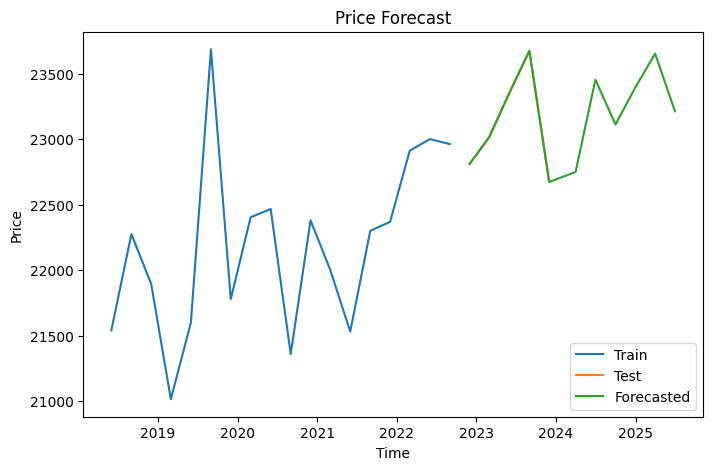

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['small']], forecast_df], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,test_small['small'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Medium

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['medium']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['medium'].tail(6).min()
max_price = df['medium'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['medium'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Medium'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 9s 6ms/step - loss: 0.2276
Epoch 2/100
22/22 [==============================] - 1s 35ms/step - loss: 0.1498
Epoch 3/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0906
Epoch 4/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0538
Epoch 5/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0514
Epoch 6/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0532
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0496
Epoch 8/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0510
Epoch 9/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0496
Epoch 10/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0481
Epoch 11/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0480
Epoch 12/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0469
Epoch 13/100
22/22 [==========

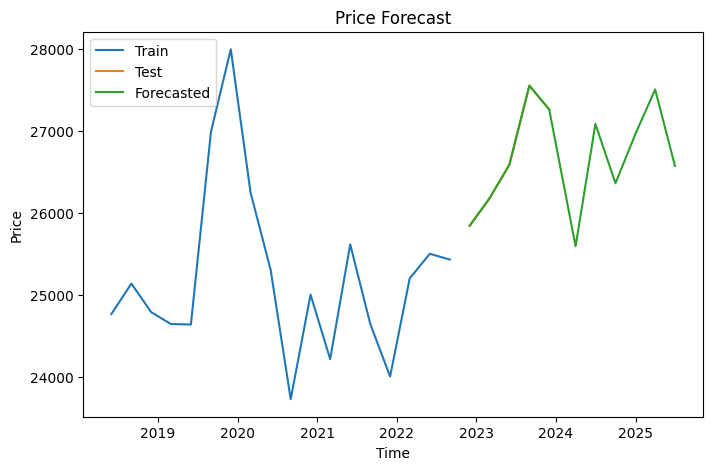

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_medium = pd.concat([test[['medium']], forecast_df], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium['Forecasted Price'],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,test_medium['medium'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###large

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['large']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['large'].tail(6).min()
max_price = df['large'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['large'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Large'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 7s 6ms/step - loss: 0.3295
Epoch 2/100
22/22 [==============================] - 0s 9ms/step - loss: 0.1915
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0722
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0352
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0355
Epoch 6/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0345
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0339
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0337
Epoch 9/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0330
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0353
Epoch 11/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0348
Epoch 12/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0324
Epoch 13/100
22/22 [================

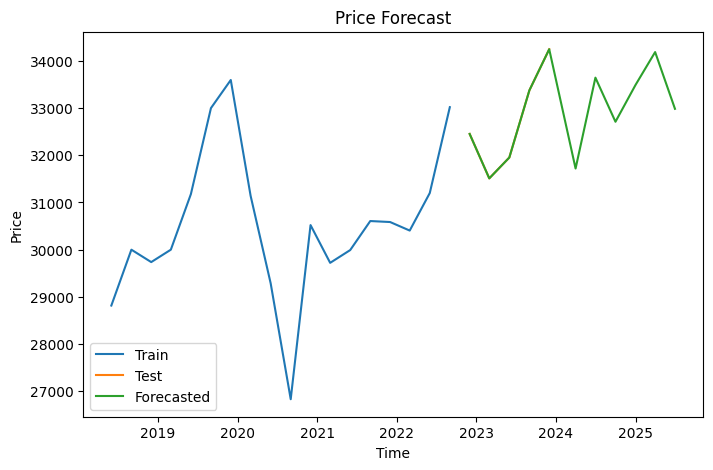

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_large = pd.concat([test[['large']], forecast_df], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large['Forecasted Price'],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,test_large['large'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Index

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['Composite Index']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['Composite Index'].tail(6).min()
max_price = df['Composite Index'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Index'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Index'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['Composite Index'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Index'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 5s 5ms/step - loss: 0.2907
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1928
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0934
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0492
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0458
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0467
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0449
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0456
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0449
Epoch 11/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 12/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0443
Epoch 13/100
22/22 [=================

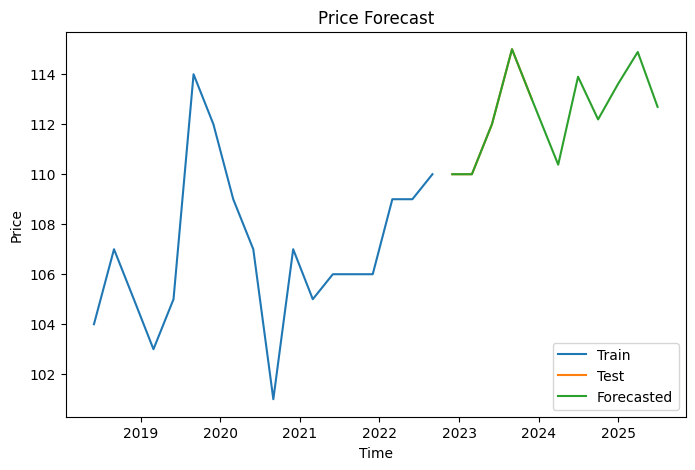

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Index'], label='Train')
plt.plot(test.index, test['Composite Index'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_index = pd.concat([test[['Composite Index']], forecast_df], ignore_index=False)
test_index['Composite Index'] = np.where(test_index['Composite Index'].isna(),test_index['Forecasted Price'],test_index['Composite Index'])
test_index = test_index[['Composite Index']]
plt.plot(test_index.index,test_index['Composite Index'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Composite Price

In [ ]:
df = df_raw[df_raw['Composite Price']!='-']
df['Composite Price'] = df['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df) * 0.8)  # 80% for training
train, test = df[0:split_point], df[split_point:]
df.shape

(23, 6)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df[['Composite Price']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['Composite Price'].tail(6).min()
max_price = df['Composite Price'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Price'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Price'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['Composite Price'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Composite Price'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 8s 6ms/step - loss: 0.2745
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1646
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0825
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0448
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0453
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0438
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0446
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0443
Epoch 10/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0435
Epoch 11/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0424
Epoch 12/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0426
Epoch 13/100
22/22 [=================

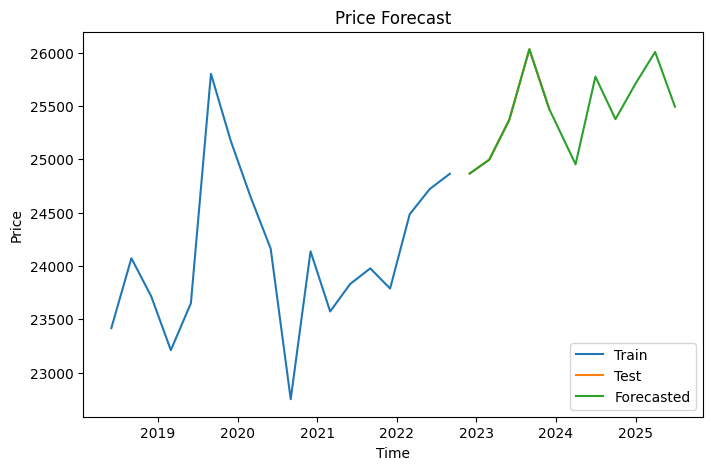

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Price'], label='Train')
plt.plot(test.index, test['Composite Price'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_price = pd.concat([test[['Composite Price']], forecast_df], ignore_index=False)
test_price['Composite Price'] = np.where(test_price['Composite Price'].isna(),test_price['Forecasted Price'],test_price['Composite Price'])
test_price = test_price[['Composite Price']]
plt.plot(test_price.index,test_price['Composite Price'], label='Forecasted')

plt.legend(loc='best')
plt.show()

##Time-GPT

###small

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['small']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='small').rename(columns={'TimeGPT':'small'})
forecast_df.tail(2)

Quarter         small
13  2026-02-28  23620.812500
14  2026-05-31  23673.832031

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['small']

Quarter
2022-12-01    22811
2023-03-01    23016
2023-06-01    23352
2023-09-01    23674
2023-12-01    22673
Name: small, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], f['small'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], f['small'][:5])
mape = mean_absolute_percentage_error(test['small'], f['small'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Small'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 422.92669154500476


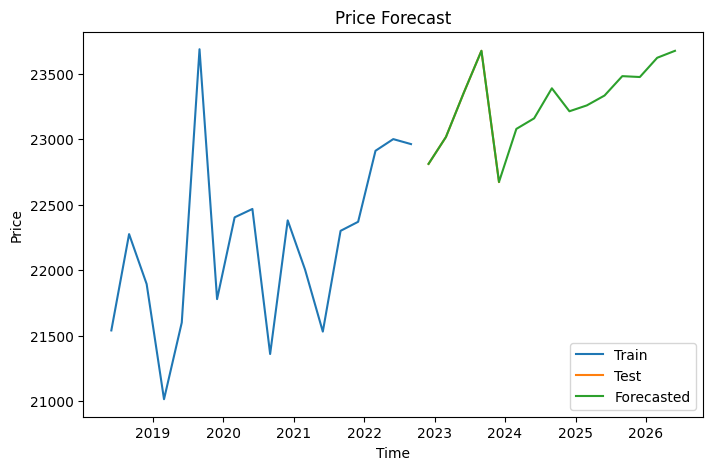

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['small']], f[['small']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,test_small['small'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Medium

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['medium']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='medium').rename(columns={'TimeGPT':'medium'})
forecast_df.tail(2)

Quarter        medium
13  2026-02-28  25602.019531
14  2026-05-31  25287.021484

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['medium']

Quarter
2022-12-01    25843
2023-03-01    26173
2023-06-01    26587
2023-09-01    27555
2023-12-01    27264
Name: medium, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], f['medium'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], f['medium'][:5])
mape = mean_absolute_percentage_error(test['medium'], f['medium'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Medium'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 1767.7055406855964


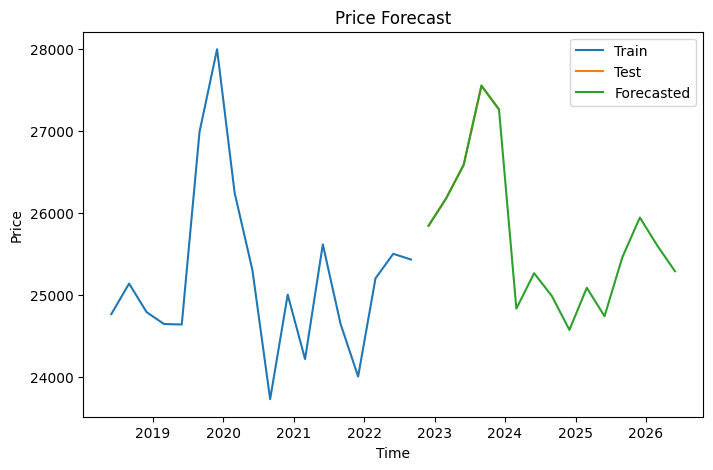

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['medium']], f[['medium']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['medium']]
plt.plot(test_small.index,test_small['medium'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Large

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['large']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='large').rename(columns={'TimeGPT':'large'})
forecast_df.tail(2)

Quarter         large
13  2026-02-28  32683.158203
14  2026-05-31  30966.255859

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['large']

Quarter
2022-12-01    32453
2023-03-01    31511
2023-06-01    31953
2023-09-01    33376
2023-12-01    34248
Name: large, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], f['large'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], f['large'][:5])
mape = mean_absolute_percentage_error(test['large'], f['large'][:5]) * 100
# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Large'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 2433.3952911460565


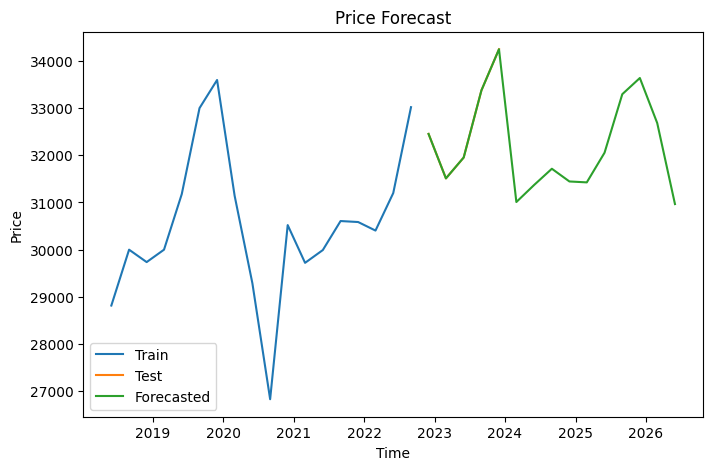

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['large']], f[['large']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['large']]
plt.plot(test_small.index,test_small['large'], label='Forecasted')

plt.legend(loc='best')
plt.show()

Best parameters: (0.4, 0.0, 0.6, 'add', 'mul')
Lowest RMSE: 338.348942599573
Test RMSE: 338.349


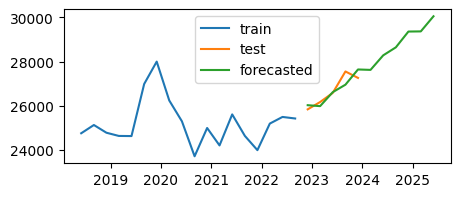

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['medium'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))

                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['medium'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['medium'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['medium'], predictions)
mape = mean_absolute_percentage_error(test['medium'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Medium'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['medium'], label='train')
plt.plot(test.index,test['medium'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_medium = pd.concat([test[['medium']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium[0],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

###Large

Best parameters: (0.2, 0.0, 0.6, 'add', 'add')
Lowest RMSE: 301.46076807478397
Test RMSE: 301.461


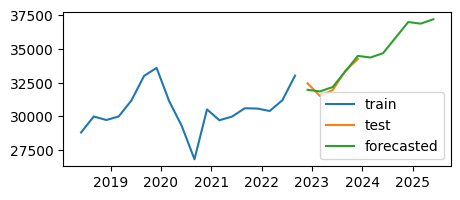

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['large'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['large'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['large'].min()
                      max_price = test['large'].max()
                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['large']))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['large'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['large'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['large'], predictions)
mape = mean_absolute_percentage_error(test['large'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Large'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['large'], label='train')
plt.plot(test.index,test['large'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_large = pd.concat([test[['large']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large[0],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

### Index

Best parameters: (0.2, 0.8, 1.0, 'add', 'mul')
Lowest RMSE: 1.1224060913488005
Test RMSE: 1.122


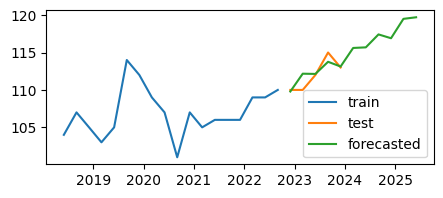

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['Composite Index'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    rmse = sqrt(mean_squared_error(test['Composite Index'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['Composite Index'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['Composite Index'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['Composite Index'], predictions)
mape = mean_absolute_percentage_error(test['Composite Index'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Index'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['Composite Index'], label='train')
plt.plot(test.index,test['Composite Index'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_Index = pd.concat([test[['Composite Index']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Index['Composite Index'] = np.where(test_Index['Composite Index'].isna(),test_Index[0],test_Index['Composite Index'])
test_Index = test_Index[['Composite Index']]
plt.plot(test_Index.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

###composite price

In [ ]:
df_raw = df_raw[df_raw['Composite Price']!='-']
df_raw['Composite Price'] = df_raw['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df_raw) * 0.8)  # 80% for training
train, test = df_raw[0:split_point], df_raw[split_point:]
df_raw.shape

(23, 6)

Best parameters: (0.2, 0.8, 1.0, 'add', 'mul')
Lowest RMSE: 189.016462764612
Test RMSE: 189.016


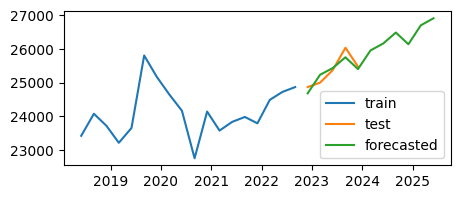

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['Composite Price'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    rmse = sqrt(mean_squared_error(test['Composite Price'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['Composite Price'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['Composite Price'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['Composite Price'], predictions)
mape = mean_absolute_percentage_error(test['Composite Price'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Composite Price'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['Composite Price'], label='train')
plt.plot(test.index,test['Composite Price'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_Price = pd.concat([test[['Composite Price']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Price['Composite Price'] = np.where(test_Price['Composite Price'].isna(),test_Price[0],test_Price['Composite Price'])
test_Price = test_Price[['Composite Price']]
plt.plot(test_Price.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

##Univariate_Arima

In [ ]:
!pip install pmdarima

###small

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=86.939, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=84.516, Time=0.42 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=86.515, Time=1.75 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=86.518, Time=1.58 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.94 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=86.048, Time=2.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=85.922, Time=2.24 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(0,

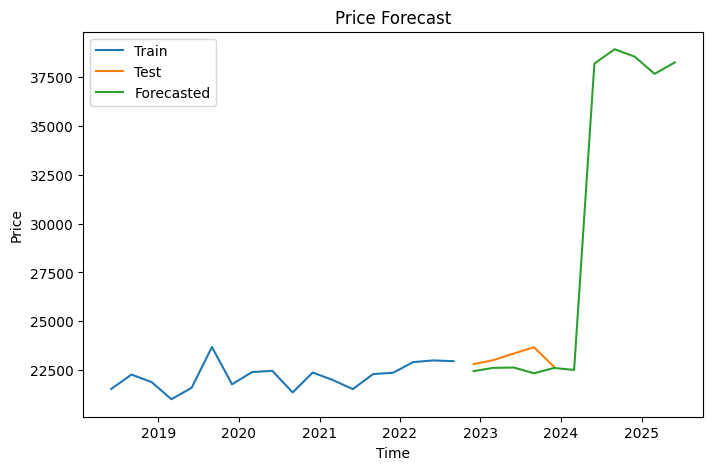

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['small'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['small'])

# Make predictions
forecast = model.predict(n_periods=len(test['small']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], forecast)
mape = mean_absolute_percentage_error(test['small'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Small'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
# plt.plot(test.index, forecast, label='Forecast')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['small'])+6)
test_small = pd.concat([test[['small']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small[0],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

###medium

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=63819811187.013, Time=0.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=88.568, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=87.119, Time=0.59 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=89.119, Time=1.30 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=87.911, Time=1.67 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=2.18 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=nan sec
 ARI

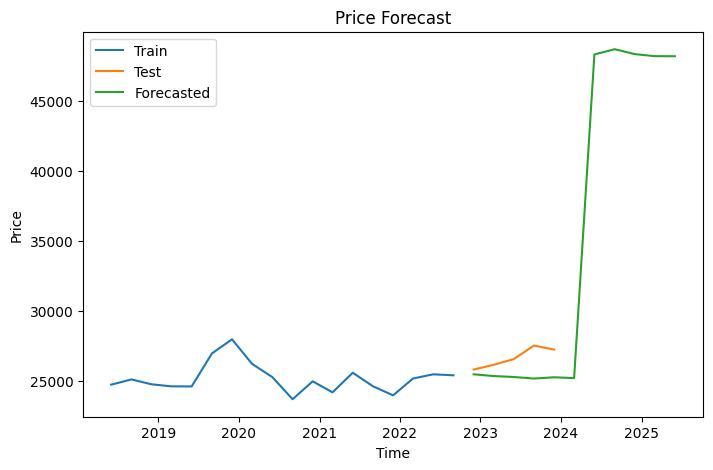

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['medium'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['medium'])

# Make predictions
forecast = model.predict(n_periods=len(test['medium']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], forecast)
mape = mean_absolute_percentage_error(test['medium'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Medium'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['medium'])+6)
test_medium = pd.concat([test[['medium']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium[0],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### large

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4803439879.714, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=75.620, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=77.847, Time=1.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=75.444, Time=0.28 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=78.428, Time=1.25 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=76.741, Time=0.09 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4803439877.714, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=74.105, Time=2.47 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=75.722, Time=1.42 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=77.

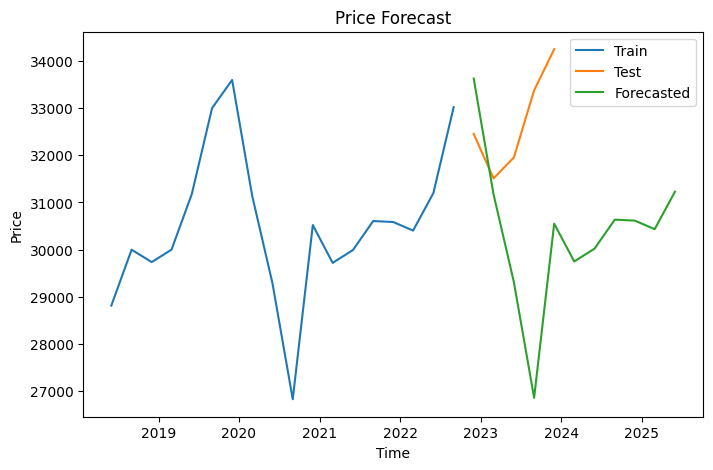

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['large'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['large'])

# Make predictions
forecast = model.predict(n_periods=len(test['large']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], forecast)
mape = mean_absolute_percentage_error(test['large'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Large'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['large'])+6)
test_large = pd.concat([test[['large']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large[0],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### Index

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=700742.389, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=31.459, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=35.371, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=33.459, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=33.459, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=35.459, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=33.371, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=33.108, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 2.209 seconds
Test RMSE: 10.334408546244182


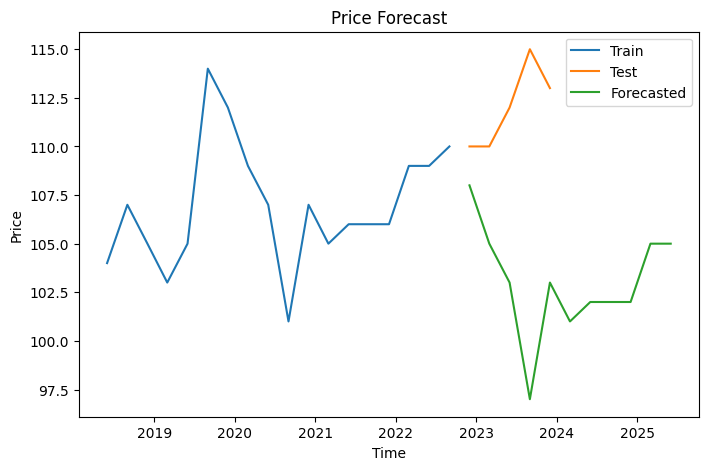

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['Composite Index'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['Composite Index'])

# Make predictions
forecast = model.predict(n_periods=len(test['Composite Index']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Index'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Index'], forecast)
mape = mean_absolute_percentage_error(test['Composite Index'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Index'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Index'], label='Train')
plt.plot(test.index, test['Composite Index'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['Composite Index'])+6)
test_Index = pd.concat([test[['Composite Index']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Index['Composite Index'] = np.where(test_Index['Composite Index'].isna(),test_Index[0],test_Index['Composite Index'])
test_Index = test_Index[['Composite Index']]
plt.plot(test_Index.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### composite price

In [ ]:
df = df_raw[df_raw['Composite Price']!='-']
df['Composite Price'] = df['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df) * 0.8)  # 80% for training
train, test = df[0:split_point], df[split_point:]
df.shape

(23, 6)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=86.021, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=83.889, Time=0.97 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.66 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=85.889, Time=2.90 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=85.911, Time=0.84 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(0,1,0)(1

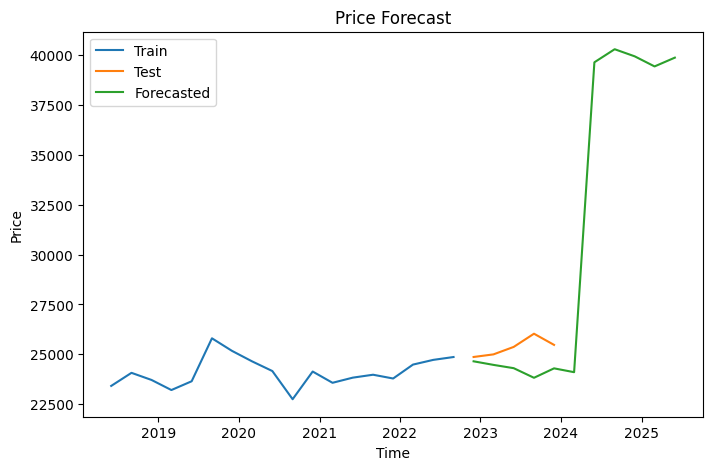

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['Composite Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['Composite Price'])

# Make predictions
forecast = model.predict(n_periods=len(test['Composite Price']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Price'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Price'], forecast)
mape = mean_absolute_percentage_error(test['Composite Price'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Composite Price'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Price'], label='Train')
plt.plot(test.index, test['Composite Price'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['Composite Price'])+6)
test_Price = pd.concat([test[['Composite Price']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Price['Composite Price'] = np.where(test_Price['Composite Price'].isna(),test_Price[0],test_Price['Composite Price'])
test_Price = test_Price[['Composite Price']]
plt.plot(test_Price.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

##ML-Model

In [ ]:
!pip install keras tensorflow

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

###Small

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['small']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['small'].tail(6).min()
max_price = df['small'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['small'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Small'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 10s 7ms/step - loss: 0.2922
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 0.1825
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0927
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0622
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0751
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0692
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0640
Epoch 8/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0649
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0631
Epoch 10/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0632
Epoch 11/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0624
Epoch 12/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0636
Epoch 13/100
22/22 [===============

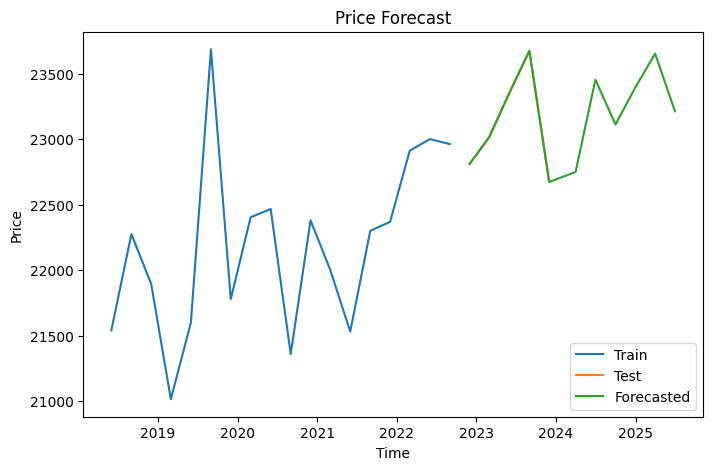

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['small']], forecast_df], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,test_small['small'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Medium

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['medium']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['medium'].tail(6).min()
max_price = df['medium'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['medium'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Medium'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 7s 7ms/step - loss: 0.2159
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1393
Epoch 3/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0799
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0553
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0548
Epoch 6/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0528
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0518
Epoch 8/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0504
Epoch 9/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0507
Epoch 10/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0501
Epoch 11/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0486
Epoch 12/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0476
Epoch 13/100
22/22 [=============

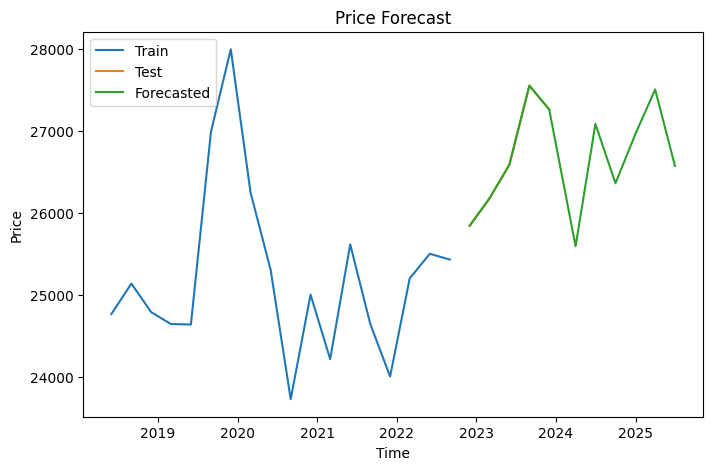

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_medium = pd.concat([test[['medium']], forecast_df], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium['Forecasted Price'],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,test_medium['medium'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###large

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['large']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['large'].tail(6).min()
max_price = df['large'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['large'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Large'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 6s 6ms/step - loss: 0.3220
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1860
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0604
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0326
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0362
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0354
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0338
Epoch 8/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0335
Epoch 9/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0336
Epoch 10/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0342
Epoch 11/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0344
Epoch 12/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0348
Epoch 13/100
22/22 [==============

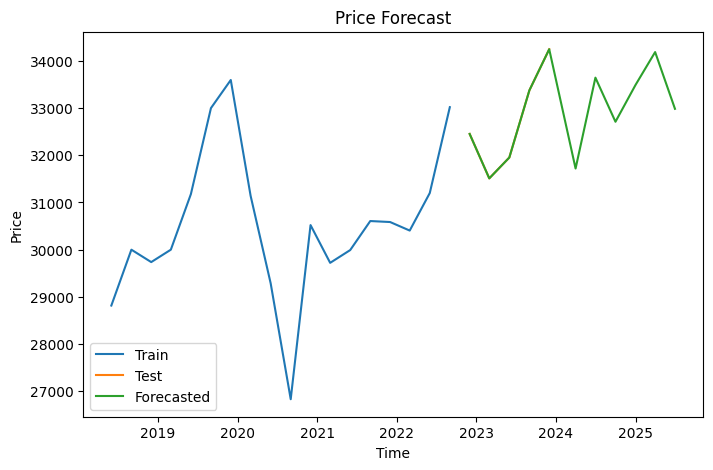

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_large = pd.concat([test[['large']], forecast_df], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large['Forecasted Price'],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,test_large['large'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Index

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['Composite Index']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['Composite Index'].tail(6).min()
max_price = df['Composite Index'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Index'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Index'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['Composite Index'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Index'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 6s 7ms/step - loss: 0.2829
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.1877
Epoch 3/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0867
Epoch 4/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0443
Epoch 5/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0462
Epoch 6/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0450
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0443
Epoch 8/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0444
Epoch 9/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0447
Epoch 10/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0428
Epoch 11/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0442
Epoch 12/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0453
Epoch 13/100
22/22 [==========

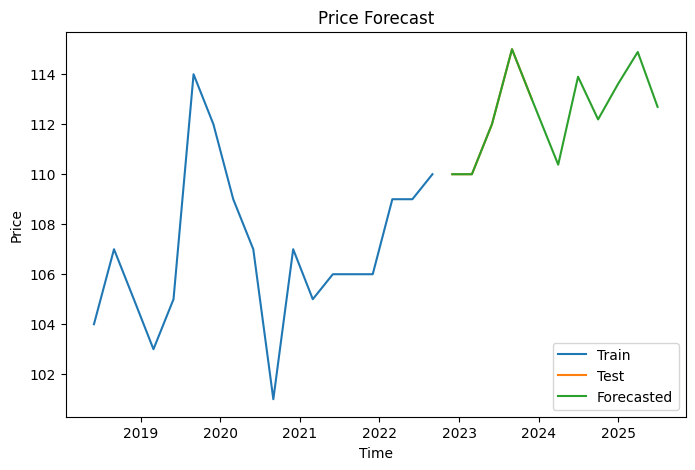

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Index'], label='Train')
plt.plot(test.index, test['Composite Index'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_index = pd.concat([test[['Composite Index']], forecast_df], ignore_index=False)
test_index['Composite Index'] = np.where(test_index['Composite Index'].isna(),test_index['Forecasted Price'],test_index['Composite Index'])
test_index = test_index[['Composite Index']]
plt.plot(test_index.index,test_index['Composite Index'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Composite Price

In [ ]:
df = df_raw[df_raw['Composite Price']!='-']
df['Composite Price'] = df['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df) * 0.8)  # 80% for training
train, test = df[0:split_point], df[split_point:]
df.shape

(23, 6)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df[['Composite Price']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['Composite Price'].tail(6).min()
max_price = df['Composite Price'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Price'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Price'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['Composite Price'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Composite Price'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 5s 6ms/step - loss: 0.2767
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1700
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0781
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0450
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0455
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0464
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0445
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0439
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 10/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0497
Epoch 11/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0459
Epoch 12/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0433
Epoch 13/100
22/22 [=================

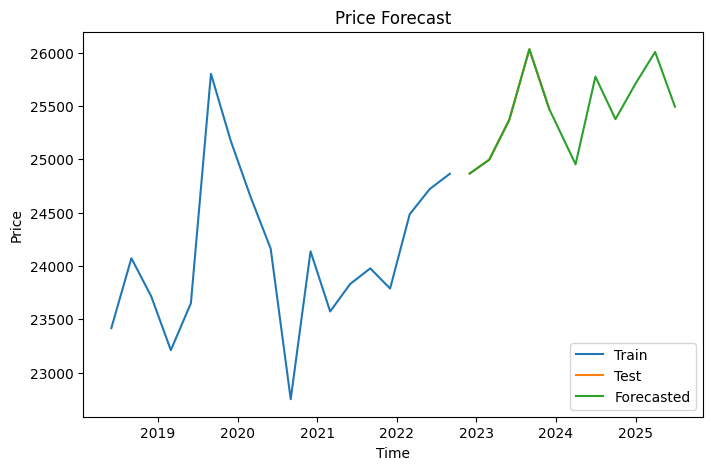

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Price'], label='Train')
plt.plot(test.index, test['Composite Price'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_price = pd.concat([test[['Composite Price']], forecast_df], ignore_index=False)
test_price['Composite Price'] = np.where(test_price['Composite Price'].isna(),test_price['Forecasted Price'],test_price['Composite Price'])
test_price = test_price[['Composite Price']]
plt.plot(test_price.index,test_price['Composite Price'], label='Forecasted')

plt.legend(loc='best')
plt.show()

##Time-GPT

###small

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['small']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='small').rename(columns={'TimeGPT':'small'})
forecast_df.tail(2)

Quarter         small
13  2026-02-28  23620.812500
14  2026-05-31  23673.832031

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['small']

Quarter
2022-12-01    22811
2023-03-01    23016
2023-06-01    23352
2023-09-01    23674
2023-12-01    22673
Name: small, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], f['small'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], f['small'][:5])
mape = mean_absolute_percentage_error(test['small'], f['small'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Small'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 422.92669154500476


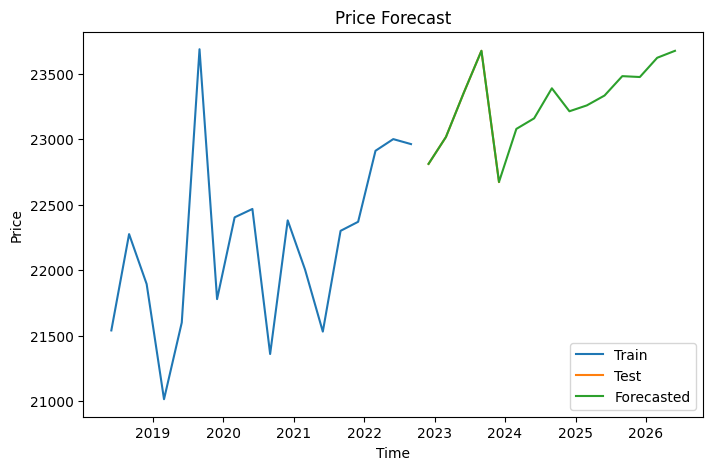

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['small']], f[['small']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,test_small['small'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Medium

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['medium']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='medium').rename(columns={'TimeGPT':'medium'})
forecast_df.tail(2)

Quarter        medium
13  2026-02-28  25602.019531
14  2026-05-31  25287.021484

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['medium']

Quarter
2022-12-01    25843
2023-03-01    26173
2023-06-01    26587
2023-09-01    27555
2023-12-01    27264
Name: medium, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], f['medium'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], f['medium'][:5])
mape = mean_absolute_percentage_error(test['medium'], f['medium'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Medium'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 1767.7055406855964


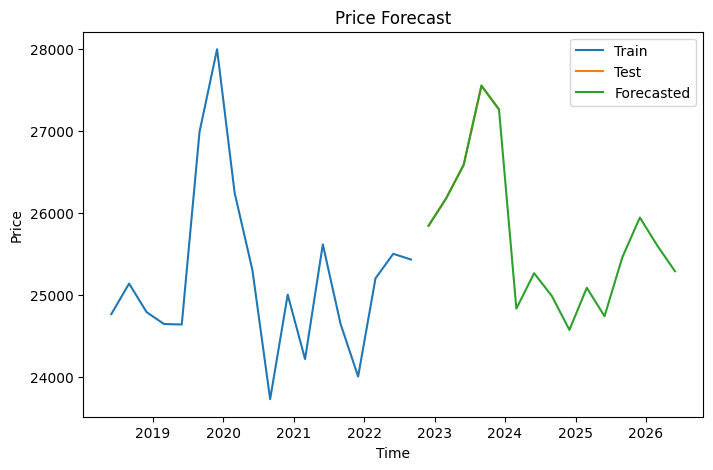

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['medium']], f[['medium']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['medium']]
plt.plot(test_small.index,test_small['medium'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Large

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['large']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='large').rename(columns={'TimeGPT':'large'})
forecast_df.tail(2)

Quarter         large
13  2026-02-28  32683.158203
14  2026-05-31  30966.255859

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['large']

Quarter
2022-12-01    32453
2023-03-01    31511
2023-06-01    31953
2023-09-01    33376
2023-12-01    34248
Name: large, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], f['large'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], f['large'][:5])
mape = mean_absolute_percentage_error(test['large'], f['large'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Mumbai'], 'Size':['Large'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 2433.3952911460565


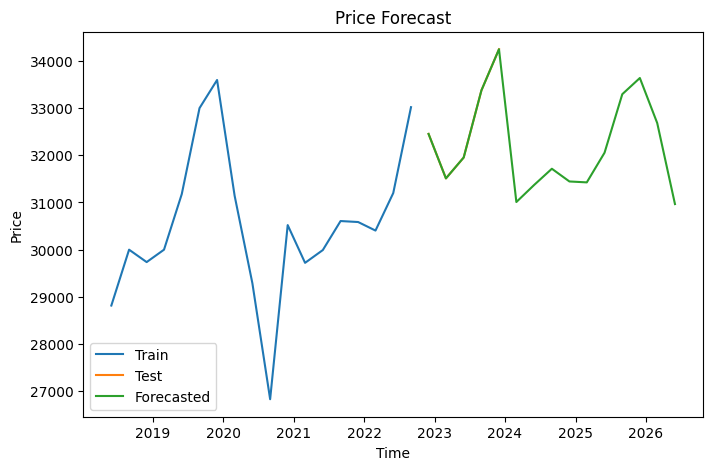

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['large']], f[['large']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['large']]
plt.plot(test_small.index,test_small['large'], label='Forecasted')

plt.legend(loc='best')
plt.show()

#   City-Hyderabad
*   Status-Ready-to-move
*   Data-NHB-Quaterly-2013-2023

In [ ]:
df_raw = raw[(raw.City=='Hyderabad') & (raw.status=='Ready to move')]
df_raw.drop(['City', 'status'],axis=1, inplace=True)
df_raw.sort_values(by=['Quarter'],ascending=True,inplace=True)

In [ ]:
# Split the data into train and test sets
split_point = int(len(df_raw) * 0.8)  # 80% for training
train, test = df_raw[0:split_point], df_raw[split_point:]
df_raw.shape

(43, 6)

In [ ]:
df_raw.tail()

Record Count  Composite Index Composite Price  small  medium  \
Quarter                                                                    
2022-12-01         12444            177.0            7364   5890    6818   
2023-03-01         12976            176.0            7294   5800    6818   
2023-06-01         11307            178.0            7392   5655    6947   
2023-09-01         13195            186.0            7727   5762    7058   
2023-12-01         13137            188.0            7807   5800    7200   

            large  
Quarter            
2022-12-01   8452  
2023-03-01   8274  
2023-06-01   8360  
2023-09-01   9082  
2023-12-01   9072

## Univariate-Exp Smoothing

###Small

Best parameters: (1.0, 0.0, 0.2, 'add', 'add')
Lowest RMSE: 160.68664203797715
Test RMSE: 160.687


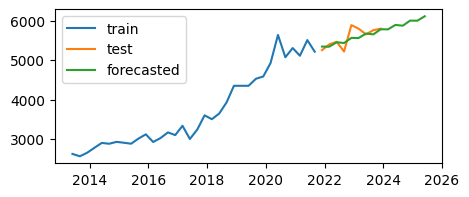

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['small'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))
                    rmse = sqrt(mean_squared_error(test['small'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['small'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['small'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['small'], predictions)
mape = mean_absolute_percentage_error(test['small'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Small'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['small'], label='train')
plt.plot(test.index,test['small'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_small = pd.concat([test[['small']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small[0],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

### Medium

Best parameters: (0.4, 0.2, 0.4, 'add', 'add')
Lowest RMSE: 43.1729552176645
Test RMSE: 43.173


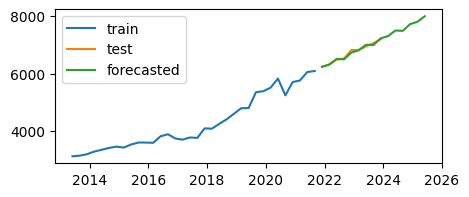

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['medium'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))

                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['medium'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['medium'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['medium'], predictions)
mape = mean_absolute_percentage_error(test['medium'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Medium'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['medium'], label='train')
plt.plot(test.index,test['medium'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_medium = pd.concat([test[['medium']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium[0],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

###Large

Best parameters: (0.8, 0.0, 0.0, 'mul', 'mul')
Lowest RMSE: 248.57904300187397
Test RMSE: 248.579


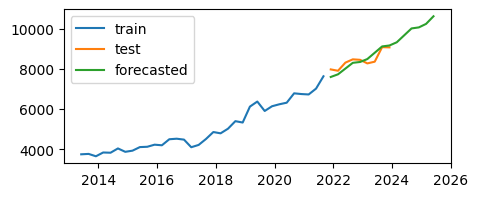

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['large'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['large'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['large'].min()
                      max_price = test['large'].max()
                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['large']))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['large'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['large'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['large'], predictions)
mape = mean_absolute_percentage_error(test['large'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Large'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['large'], label='train')
plt.plot(test.index,test['large'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_large = pd.concat([test[['large']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large[0],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

### Index

Best parameters: (1.0, 1.0, 0.4, 'mul', 'mul')
Lowest RMSE: 5046.196994584286
Test RMSE: 2141.966


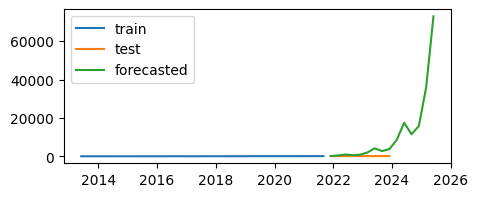

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['Composite Index'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    rmse = sqrt(mean_squared_error(test['Composite Index'], predictions))
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['Composite Index'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['Composite Index'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['Composite Index'], predictions)
mape = mean_absolute_percentage_error(test['Composite Index'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Index'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['Composite Index'], label='train')
plt.plot(test.index,test['Composite Index'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_Index = pd.concat([test[['Composite Index']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Index['Composite Index'] = np.where(test_Index['Composite Index'].isna(),test_Index[0],test_Index['Composite Index'])
test_Index = test_Index[['Composite Index']]
plt.plot(test_Index.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

##Univariate_Arima

In [ ]:
!pip install pmdarima

###small

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=309.796, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=306.914, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=309.524, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=308.769, Time=0.80 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.40 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.41 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=308.394, Time=0.34 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=308.913, Time=0.73 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=308.913, Time=0.96 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=307.314, Time=0.40 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=307.771, Time=

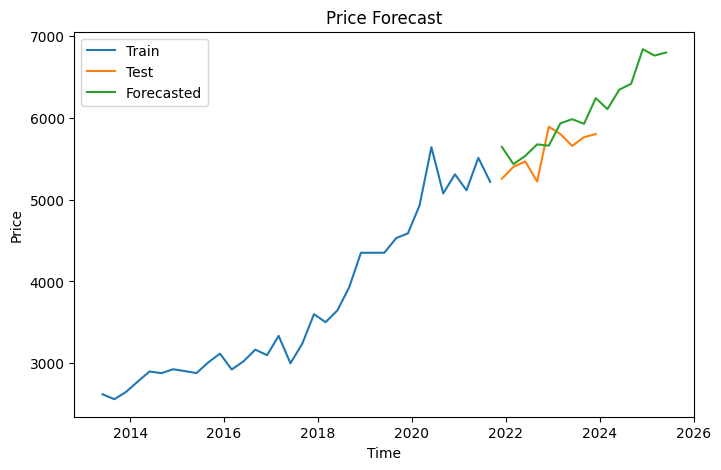

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['small'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['small'])

# Make predictions
forecast = model.predict(n_periods=len(test['small']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], forecast)
mape = mean_absolute_percentage_error(test['small'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Small'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
# plt.plot(test.index, forecast, label='Forecast')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['small'])+6)
test_small = pd.concat([test[['small']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small[0],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

###medium

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=293.642, Time=0.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=288.200, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=291.717, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=291.774, Time=0.37 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=289.945, Time=0.12 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=289.942, Time=0.21 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=291.936, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=289.739, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=289.827, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=291.662, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=289.225, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 2.329 seconds
Test RMSE: 309.5362122057235


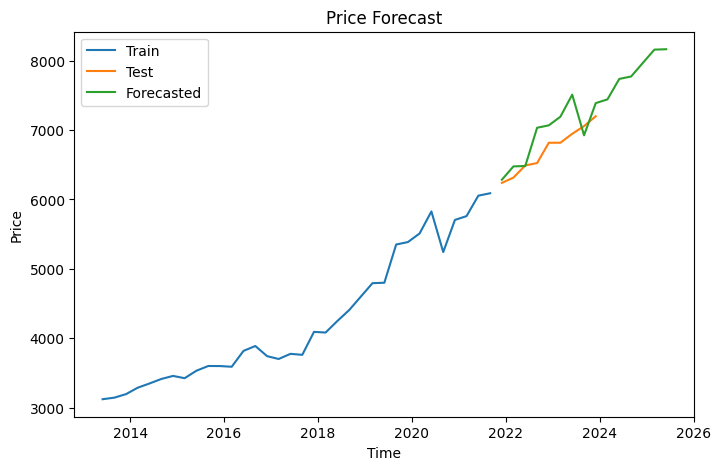

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['medium'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['medium'])

# Make predictions
forecast = model.predict(n_periods=len(test['medium']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], forecast)
mape = mean_absolute_percentage_error(test['medium'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Medium'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['medium'])+6)
test_medium = pd.concat([test[['medium']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium[0],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### large

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=308.098, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=304.858, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=306.336, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=306.134, Time=0.24 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=304.875, Time=0.37 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=306.860, Time=1.45 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=306.146, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=305.875, Time=0.15 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=307.801, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=305.857, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 3.758 seconds
Test RMSE: 271.7848413727302


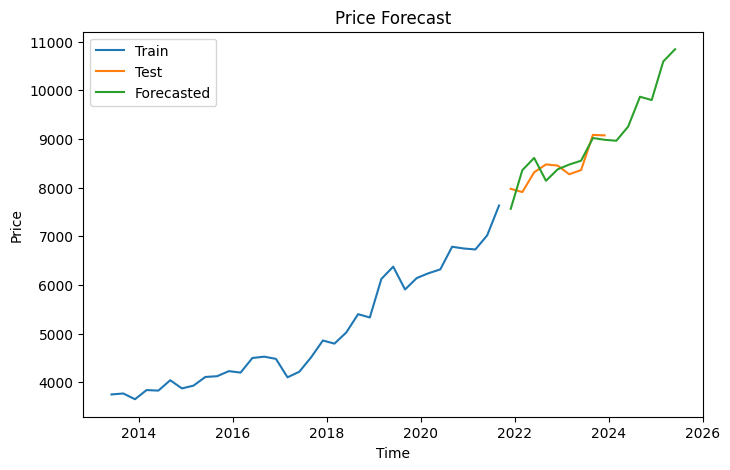

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['large'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['large'])

# Make predictions
forecast = model.predict(n_periods=len(test['large']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], forecast)
mape = mean_absolute_percentage_error(test['large'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Large'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['large'])+6)
test_large = pd.concat([test[['large']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large[0],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### Index

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=125.483, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=127.733, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=125.856, Time=0.20 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=125.856, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=127.856, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=127.437, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=127.443, Time=0.09 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=129.112, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=125.621, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 5.300 seconds
Test RMSE: 6.0827625303001245


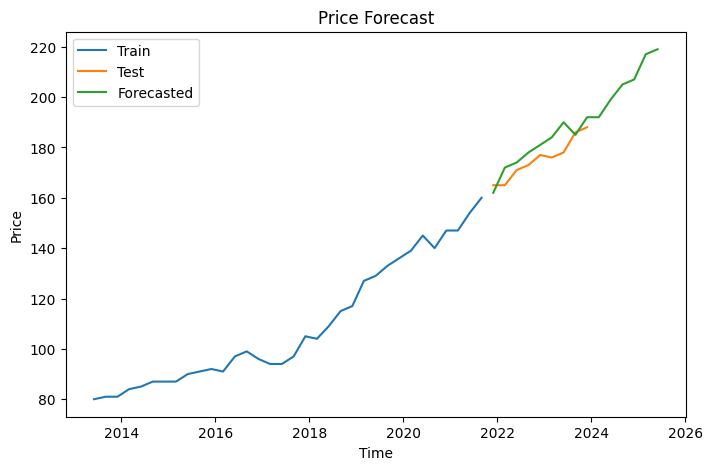

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['Composite Index'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['Composite Index'])

# Make predictions
forecast = model.predict(n_periods=len(test['Composite Index']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Index'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Index'], forecast)
mape = mean_absolute_percentage_error(test['Composite Index'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Index'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Index'], label='Train')
plt.plot(test.index, test['Composite Index'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['Composite Index'])+6)
test_Index = pd.concat([test[['Composite Index']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Index['Composite Index'] = np.where(test_Index['Composite Index'].isna(),test_Index[0],test_Index['Composite Index'])
test_Index = test_Index[['Composite Index']]
plt.plot(test_Index.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### composite price

In [ ]:
df = df_raw[df_raw['Composite Price']!='-']
df['Composite Price'] = df['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df) * 0.8)  # 80% for training
train, test = df[0:split_point], df[split_point:]
df.shape

(23, 6)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=68.727, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=71.138, Time=0.23 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=72.457, Time=0.92 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=68.766, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=69.253, Time=0.15 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=72.368, Time=0.74 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=70.453, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 5.502 seconds
Test RMSE: 183.9151978494437


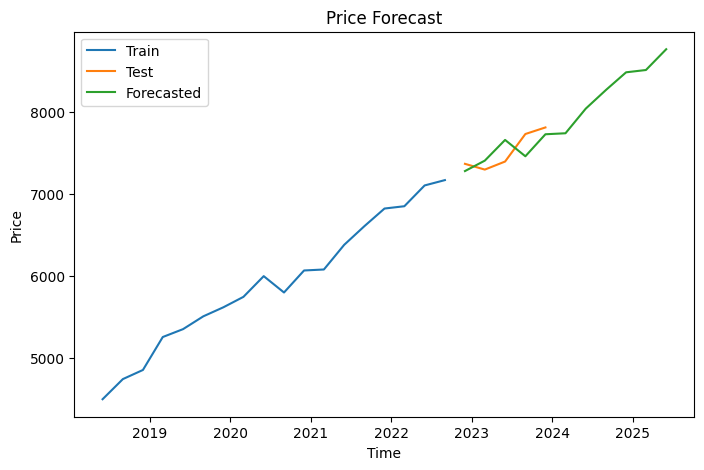

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['Composite Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['Composite Price'])

# Make predictions
forecast = model.predict(n_periods=len(test['Composite Price']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Price'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Price'], forecast)
mape = mean_absolute_percentage_error(test['Composite Price'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Composite Price'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Price'], label='Train')
plt.plot(test.index, test['Composite Price'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['Composite Price'])+6)
test_Price = pd.concat([test[['Composite Price']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Price['Composite Price'] = np.where(test_Price['Composite Price'].isna(),test_Price[0],test_Price['Composite Price'])
test_Price = test_Price[['Composite Price']]
plt.plot(test_Price.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

##ML-Model

In [ ]:
!pip install keras tensorflow

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

###Small

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['small']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['small'].tail(6).min()
max_price = df['small'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['small'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Small'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
42/42 [==============================] - 8s 6ms/step - loss: 0.2620
Epoch 2/100
42/42 [==============================] - 0s 7ms/step - loss: 0.0922
Epoch 3/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0394
Epoch 4/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0275
Epoch 5/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0169
Epoch 6/100
42/42 [==============================] - 0s 7ms/step - loss: 0.0114
Epoch 7/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 8/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 9/100
42/42 [==============================] - 0s 7ms/step - loss: 0.0079
Epoch 10/100
42/42 [==============================] - 0s 7ms/step - loss: 0.0066
Epoch 11/100
42/42 [==============================] - 0s 7ms/step - loss: 0.0076
Epoch 12/100
42/42 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 13/100
42/42 [================

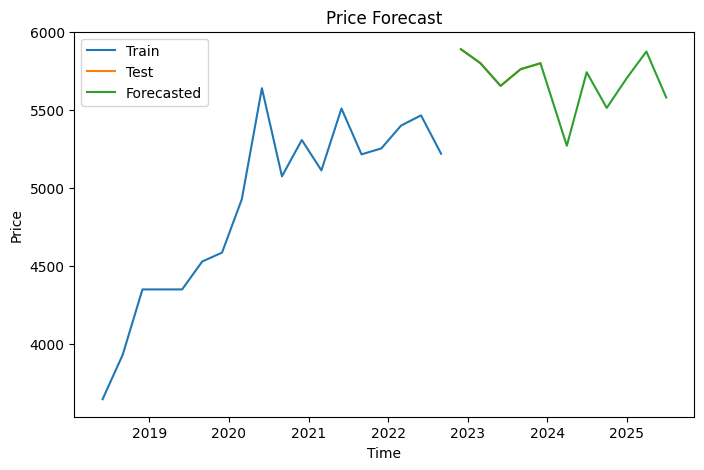

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['small']], forecast_df], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,test_small['small'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Medium

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['medium']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['medium'].tail(6).min()
max_price = df['medium'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['medium'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Medium'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
42/42 [==============================] - 7s 9ms/step - loss: 0.2076
Epoch 2/100
42/42 [==============================] - 0s 7ms/step - loss: 0.0719
Epoch 3/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0379
Epoch 4/100
42/42 [==============================] - 0s 7ms/step - loss: 0.0236
Epoch 5/100
42/42 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 6/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0061
Epoch 7/100
42/42 [==============================] - 0s 11ms/step - loss: 0.0035
Epoch 8/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0029
Epoch 9/100
42/42 [==============================] - 1s 12ms/step - loss: 0.0032
Epoch 10/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0032
Epoch 11/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0029
Epoch 12/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 13/100
42/42 [=============

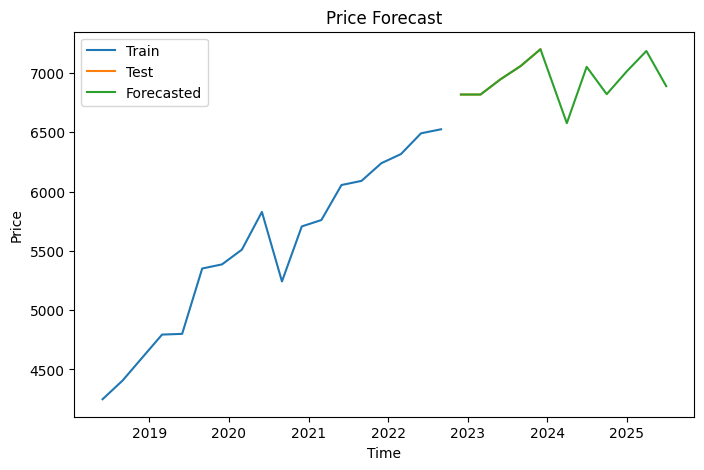

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_medium = pd.concat([test[['medium']], forecast_df], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium['Forecasted Price'],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,test_medium['medium'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###large

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['large']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['large'].tail(6).min()
max_price = df['large'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['large'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Large'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
42/42 [==============================] - 6s 6ms/step - loss: 0.1923
Epoch 2/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0697
Epoch 3/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0395
Epoch 4/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0242
Epoch 5/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0128
Epoch 6/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 7/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 8/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 9/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 10/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 11/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 12/100
42/42 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 13/100
42/42 [=================

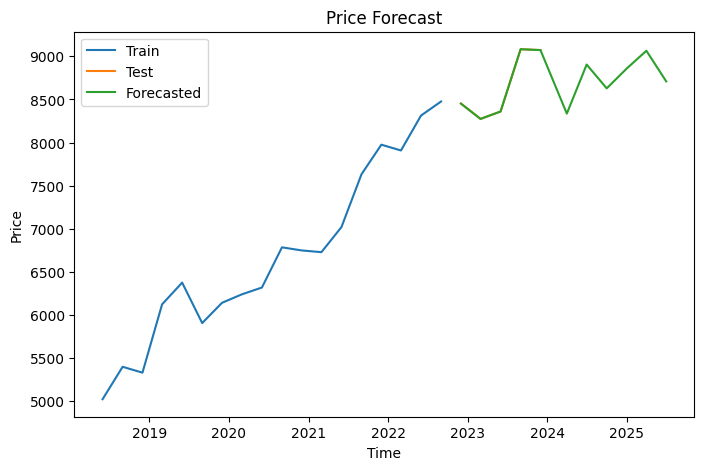

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_large = pd.concat([test[['large']], forecast_df], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large['Forecasted Price'],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,test_large['large'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Index

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['Composite Index']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['Composite Index'].tail(6).min()
max_price = df['Composite Index'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Index'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Index'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['Composite Index'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Index'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
42/42 [==============================] - 6s 8ms/step - loss: 0.2120
Epoch 2/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0919
Epoch 3/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0380
Epoch 4/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0259
Epoch 5/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0118
Epoch 6/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0050
Epoch 7/100
42/42 [==============================] - 0s 12ms/step - loss: 0.0024
Epoch 8/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 9/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 10/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 11/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 12/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 13/100
42/42 [===========

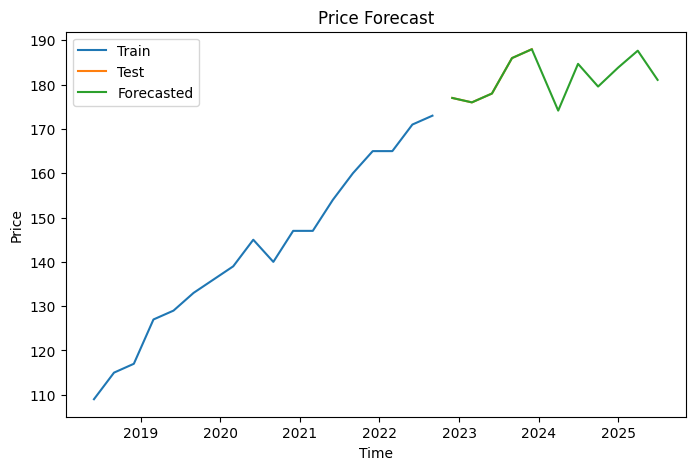

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Index'], label='Train')
plt.plot(test.index, test['Composite Index'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_index = pd.concat([test[['Composite Index']], forecast_df], ignore_index=False)
test_index['Composite Index'] = np.where(test_index['Composite Index'].isna(),test_index['Forecasted Price'],test_index['Composite Index'])
test_index = test_index[['Composite Index']]
plt.plot(test_index.index,test_index['Composite Index'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Composite Price

In [ ]:
df = df_raw[df_raw['Composite Price']!='-']
df['Composite Price'] = df['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df) * 0.8)  # 80% for training
train, test = df[0:split_point], df[split_point:]
df.shape

(23, 6)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df[['Composite Price']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['Composite Price'].tail(6).min()
max_price = df['Composite Price'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Price'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Price'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['Composite Price'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Composite Price'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 7s 8ms/step - loss: 0.3210
Epoch 2/100
22/22 [==============================] - 0s 10ms/step - loss: 0.1855
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0674
Epoch 4/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0323
Epoch 5/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0240
Epoch 6/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0192
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0171
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 9/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0111
Epoch 10/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0092
Epoch 11/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0070
Epoch 12/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 13/100
22/22 [============

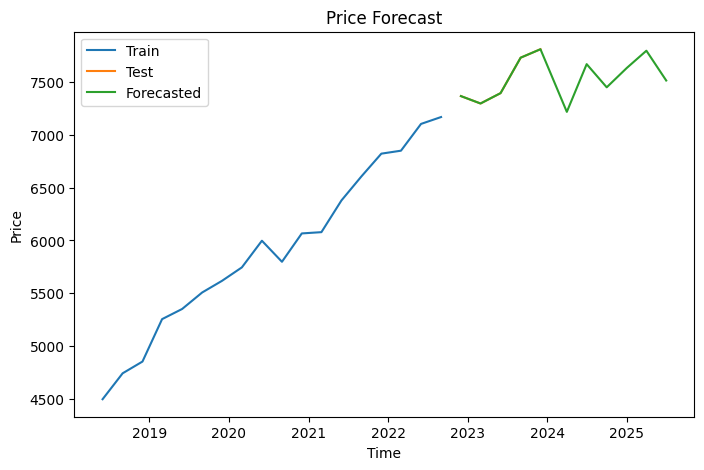

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Price'], label='Train')
plt.plot(test.index, test['Composite Price'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_price = pd.concat([test[['Composite Price']], forecast_df], ignore_index=False)
test_price['Composite Price'] = np.where(test_price['Composite Price'].isna(),test_price['Forecasted Price'],test_price['Composite Price'])
test_price = test_price[['Composite Price']]
plt.plot(test_price.index,test_price['Composite Price'], label='Forecasted')

plt.legend(loc='best')
plt.show()

##Time-GPT

###small

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['small']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='small').rename(columns={'TimeGPT':'small'})
forecast_df.tail(2)

Quarter        small
13  2026-02-28  5948.884277
14  2026-05-31  6154.431641

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['small']

Quarter
2022-12-01    5890
2023-03-01    5800
2023-06-01    5655
2023-09-01    5762
2023-12-01    5800
Name: small, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], f['small'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], f['small'][:5])
mape = mean_absolute_percentage_error(test['small'], f['small'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Small'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 266.4616990862035


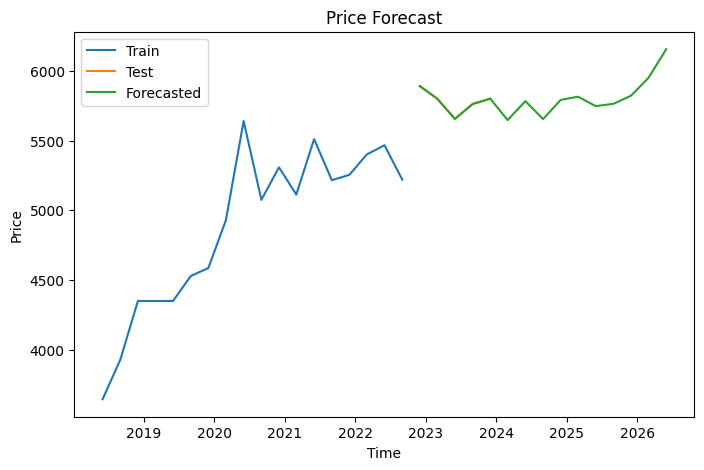

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['small']], f[['small']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,test_small['small'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Medium

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['medium']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='medium').rename(columns={'TimeGPT':'medium'})
forecast_df.tail(2)

Quarter       medium
13  2026-02-28  7768.589355
14  2026-05-31  7924.199219

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['medium']

Quarter
2022-12-01    6818
2023-03-01    6818
2023-06-01    6947
2023-09-01    7058
2023-12-01    7200
Name: medium, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], f['medium'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], f['medium'][:5])
mape = mean_absolute_percentage_error(test['medium'], f['medium'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Medium'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 146.4509004006166


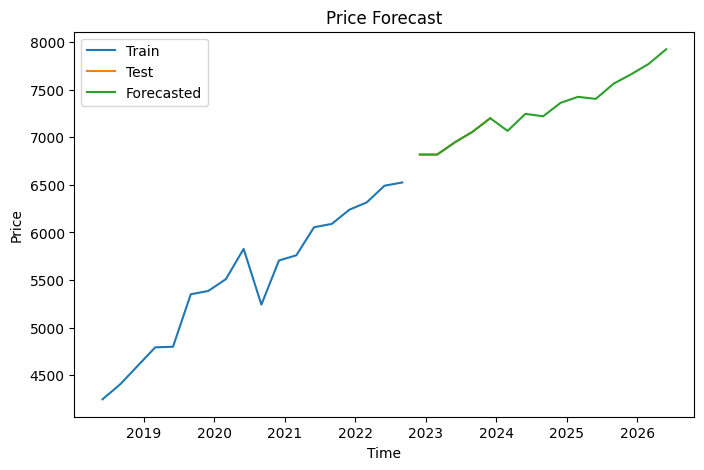

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['medium']], f[['medium']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['medium']]
plt.plot(test_small.index,test_small['medium'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Large

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['large']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='large').rename(columns={'TimeGPT':'large'})
forecast_df.tail(2)

Quarter         large
13  2026-02-28  10197.505859
14  2026-05-31  10326.732422

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['large']

Quarter
2022-12-01    8452
2023-03-01    8274
2023-06-01    8360
2023-09-01    9082
2023-12-01    9072
Name: large, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], f['large'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], f['large'][:5])
mape = mean_absolute_percentage_error(test['large'], f['large'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Hyderabad'], 'Size':['Large'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 437.2967359350371


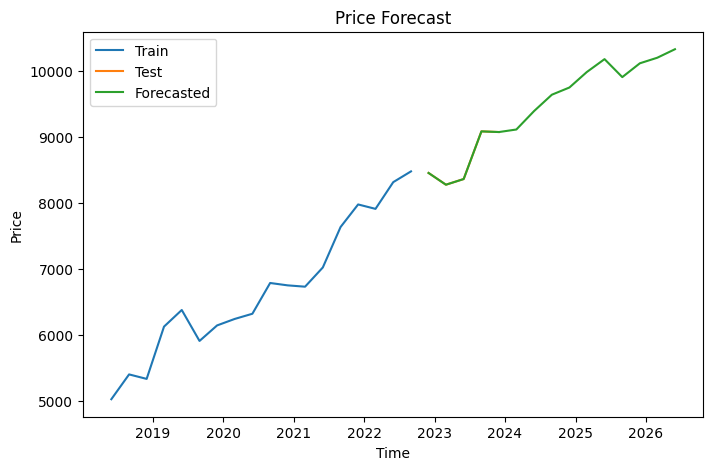

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['large']], f[['large']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['large']]
plt.plot(test_small.index,test_small['large'], label='Forecasted')

plt.legend(loc='best')
plt.show()

#   City-Bengaluru
*   Status-Ready-to-move
*   Data-NHB-Quaterly-2013-2023

In [ ]:
df_raw = raw[(raw.City=='Bengaluru') & (raw.status=='Ready to move')]
df_raw.drop(['City', 'status'],axis=1, inplace=True)
df_raw.sort_values(by=['Quarter'],ascending=True,inplace=True)

In [ ]:
# Split the data into train and test sets
split_point = int(len(df_raw) * 0.8)  # 80% for training
train, test = df_raw[0:split_point], df_raw[split_point:]
df_raw.shape

(43, 6)

In [ ]:
df_raw.tail()

Record Count  Composite Index Composite Price  small  medium  \
Quarter                                                                    
2022-12-01         10828            133.0            8565   9081    8126   
2023-03-01         12512            133.0            8566   9682    8093   
2023-06-01          9105            136.0            8726  10141    8239   
2023-09-01         13396            140.0            8995   9708    8448   
2023-12-01         11203            143.0            9173  10083    8411   

            large  
Quarter            
2022-12-01   9250  
2023-03-01   9202  
2023-06-01   9331  
2023-09-01   9834  
2023-12-01  10358

## Univariate-Exp Smoothing

###Small

Best parameters: (0.6, 0.2, 0.0, 'add', 'mul')
Lowest RMSE: 309.735611828499
Test RMSE: 309.736


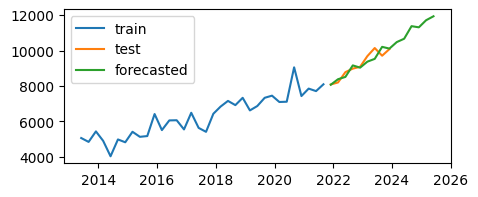

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['small'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))
                    rmse = sqrt(mean_squared_error(test['small'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['small'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['small'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['small'], predictions)
mape = mean_absolute_percentage_error(test['small'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Small'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['small'], label='train')
plt.plot(test.index,test['small'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_small = pd.concat([test[['small']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small[0],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

### Medium

Best parameters: (0.4, 0.2, 0.0, 'mul', 'add')
Lowest RMSE: 114.90970626752623
Test RMSE: 114.910


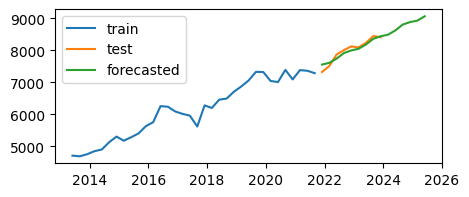

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['medium'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))

                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['medium'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['medium'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['medium'], predictions)
mape = mean_absolute_percentage_error(test['medium'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Medium'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['medium'], label='train')
plt.plot(test.index,test['medium'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_medium = pd.concat([test[['medium']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium[0],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

###Large

Best parameters: (1.0, 0.0, 0.0, 'add', 'mul')
Lowest RMSE: 148.51002203406392
Test RMSE: 148.510


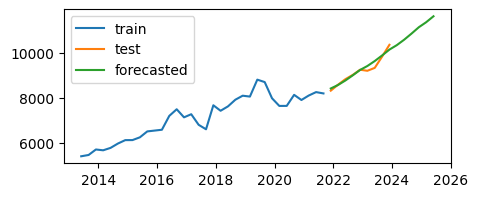

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['large'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['large'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['large'].min()
                      max_price = test['large'].max()
                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['large']))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['large'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['large'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['large'], predictions)
mape = mean_absolute_percentage_error(test['large'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Large'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['large'], label='train')
plt.plot(test.index,test['large'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_large = pd.concat([test[['large']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large[0],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

### Index

Best parameters: (0.2, 0.0, 0.0, 'mul', 'mul')
Lowest RMSE: 2.2285690249160064
Test RMSE: 2.229


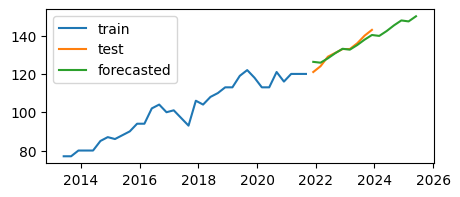

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['Composite Index'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))
                    rmse = sqrt(mean_squared_error(test['Composite Index'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['Composite Index'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['Composite Index'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['Composite Index'], predictions)
mape = mean_absolute_percentage_error(test['Composite Index'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Index'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['Composite Index'], label='train')
plt.plot(test.index,test['Composite Index'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_Index = pd.concat([test[['Composite Index']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Index['Composite Index'] = np.where(test_Index['Composite Index'].isna(),test_Index[0],test_Index['Composite Index'])
test_Index = test_Index[['Composite Index']]
plt.plot(test_Index.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

###composite price

In [ ]:
df_raw = df_raw[df_raw['Composite Price']!='-']
df_raw['Composite Price'] = df_raw['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df_raw) * 0.8)  # 80% for training
train, test = df_raw[0:split_point], df_raw[split_point:]
df_raw.shape

(23, 6)

Best parameters: (0.8, 0.4, 0.8, 'add', 'add')
Lowest RMSE: 50.67484294737964
Test RMSE: 50.675


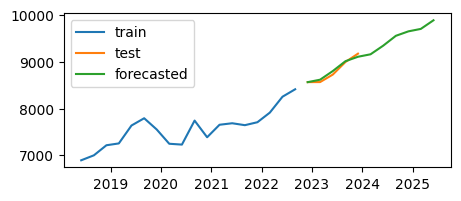

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['Composite Price'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))
                    rmse = sqrt(mean_squared_error(test['Composite Price'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['Composite Price'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['Composite Price'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['Composite Price'], predictions)
mape = mean_absolute_percentage_error(test['Composite Price'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Composite Price'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['Composite Price'], label='train')
plt.plot(test.index,test['Composite Price'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_Price = pd.concat([test[['Composite Price']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Price['Composite Price'] = np.where(test_Price['Composite Price'].isna(),test_Price[0],test_Price['Composite Price'])
test_Price = test_Price[['Composite Price']]
plt.plot(test_Price.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

##Univariate_Arima

In [ ]:
!pip install pmdarima

###small

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=9436413654.958, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=79.007, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=81.390, Time=0.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=78.997, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=81.742, Time=0.49 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=80.783, Time=0.22 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=79.321, Time=0.23 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=79.136, Time=0.25 s

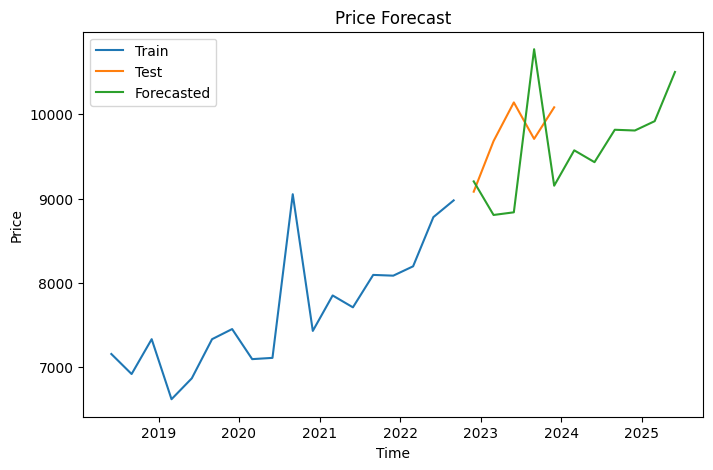

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['small'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['small'])

# Make predictions
forecast = model.predict(n_periods=len(test['small']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], forecast)
mape = mean_absolute_percentage_error(test['small'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Small'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
# plt.plot(test.index, forecast, label='Forecast')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['small'])+6)
test_small = pd.concat([test[['small']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small[0],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

###medium

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5690610220.423, Time=0.65 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=65.381, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=69.303, Time=1.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=67.341, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5690610218.423, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=66.820, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 5.716 seconds
Test RMSE: 447.61568337134923


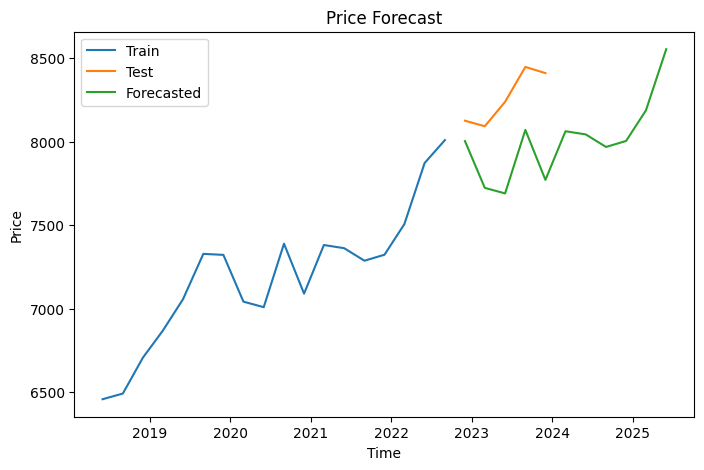

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['medium'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['medium'])

# Make predictions
forecast = model.predict(n_periods=len(test['medium']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], forecast)
mape = mean_absolute_percentage_error(test['medium'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Medium'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['medium'])+6)
test_medium = pd.concat([test[['medium']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium[0],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### large

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=415947395.967, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=74.383, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=77.384, Time=0.99 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=76.340, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=76.343, Time=0.10 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=415947393.967, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=76.205, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 3.949 seconds
Test RMSE: 1469.1901170372744


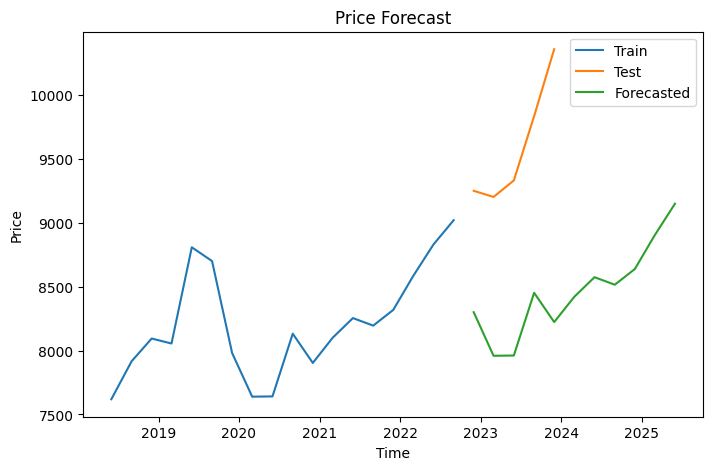

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['large'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['large'])

# Make predictions
forecast = model.predict(n_periods=len(test['large']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], forecast)
mape = mean_absolute_percentage_error(test['large'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Large'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['large'])+6)
test_large = pd.concat([test[['large']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large[0],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### Index

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=123732.033, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=22.864, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=26.621, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=24.864, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=24.864, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=26.864, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=24.621, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=24.367, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 2.770 seconds
Test RMSE: 12.46595363373608


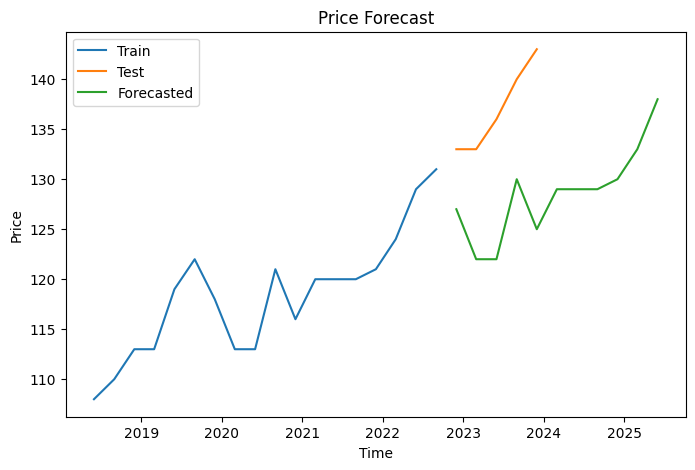

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['Composite Index'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['Composite Index'])

# Make predictions
forecast = model.predict(n_periods=len(test['Composite Index']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Index'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Index'], forecast)
mape = mean_absolute_percentage_error(test['Composite Index'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Index'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Index'], label='Train')
plt.plot(test.index, test['Composite Index'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['Composite Index'])+6)
test_Index = pd.concat([test[['Composite Index']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Index['Composite Index'] = np.where(test_Index['Composite Index'].isna(),test_Index[0],test_Index['Composite Index'])
test_Index = test_Index[['Composite Index']]
plt.plot(test_Index.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### composite price

In [ ]:
df = df_raw[df_raw['Composite Price']!='-']
df['Composite Price'] = df['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df) * 0.8)  # 80% for training
train, test = df[0:split_point], df[split_point:]
df.shape

(23, 6)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4067291702.010, Time=1.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=64.210, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=1.47 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=68.100, Time=1.69 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=66.194, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4067291700.010, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=65.794, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 7.109 seconds
Test RMSE: 796.8383775898347


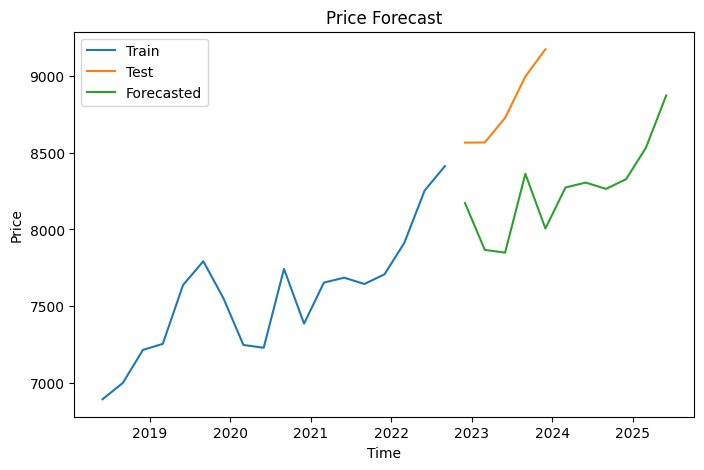

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['Composite Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['Composite Price'])

# Make predictions
forecast = model.predict(n_periods=len(test['Composite Price']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Price'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Price'], forecast)
mape = mean_absolute_percentage_error(test['Composite Price'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Composite Price'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Price'], label='Train')
plt.plot(test.index, test['Composite Price'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['Composite Price'])+6)
test_Price = pd.concat([test[['Composite Price']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Price['Composite Price'] = np.where(test_Price['Composite Price'].isna(),test_Price[0],test_Price['Composite Price'])
test_Price = test_Price[['Composite Price']]
plt.plot(test_Price.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

##ML-Model

In [ ]:
!pip install keras tensorflow

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

###Small

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['small']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['small'].tail(6).min()
max_price = df['small'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['small'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Small'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 6s 7ms/step - loss: 0.2505
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.1837
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 0.1061
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0613
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0561
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0525
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0509
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0464
Epoch 9/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0430
Epoch 10/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0409
Epoch 11/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0405
Epoch 12/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0367
Epoch 13/100
22/22 [================

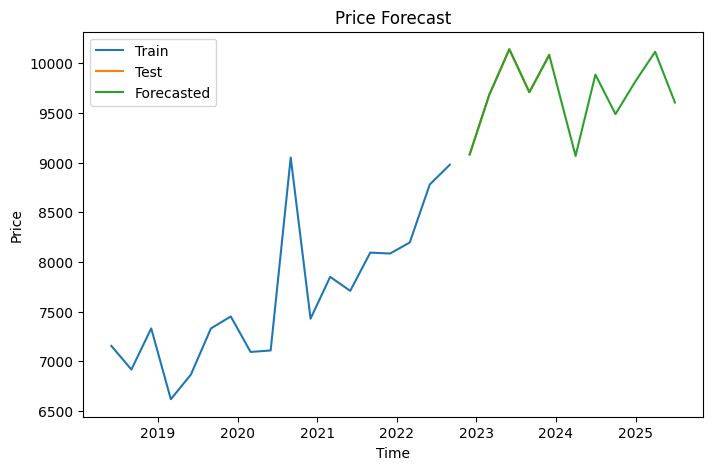

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['small']], forecast_df], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,test_small['small'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Medium

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['medium']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['medium'].tail(6).min()
max_price = df['medium'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['medium'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Medium'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 7s 7ms/step - loss: 0.2867
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 0.1840
Epoch 3/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0846
Epoch 4/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0367
Epoch 5/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0311
Epoch 6/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0262
Epoch 7/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0245
Epoch 8/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0220
Epoch 9/100
22/22 [==============================] - 0s 15ms/step - loss: 0.0188
Epoch 10/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0163
Epoch 11/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0148
Epoch 12/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0122
Epoch 13/100
22/22 [==========

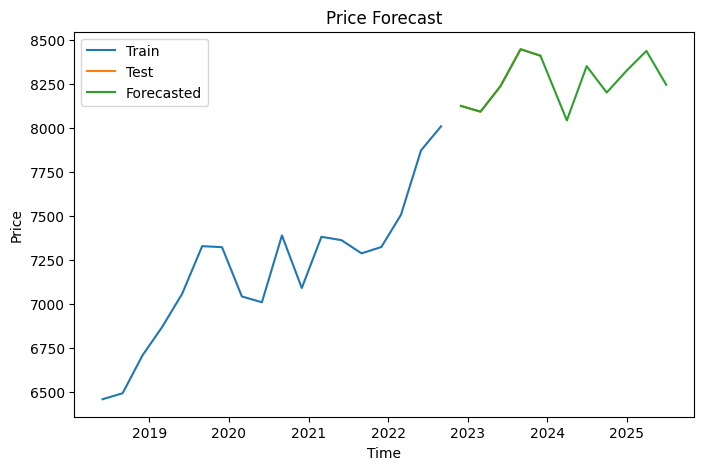

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_medium = pd.concat([test[['medium']], forecast_df], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium['Forecasted Price'],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,test_medium['medium'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###large

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['large']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['large'].tail(6).min()
max_price = df['large'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['large'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Large'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 10s 6ms/step - loss: 0.1511
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.1023
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0577
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0504
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0408
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0383
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0346
Epoch 8/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0312
Epoch 9/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0287
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0250
Epoch 11/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0225
Epoch 12/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 13/100
22/22 [===============

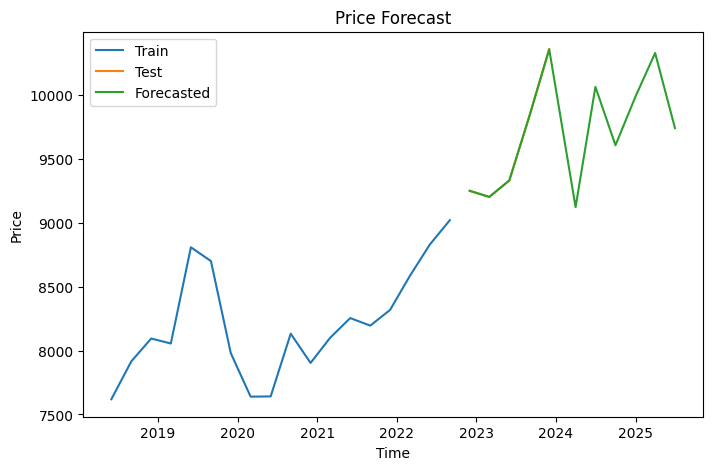

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_large = pd.concat([test[['large']], forecast_df], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large['Forecasted Price'],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,test_large['large'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Index

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['Composite Index']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['Composite Index'].tail(6).min()
max_price = df['Composite Index'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Index'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Index'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['Composite Index'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Index'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 8s 6ms/step - loss: 0.2183
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 0.1348
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0653
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0395
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0313
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0273
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0245
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0175
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0152
Epoch 11/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0139
Epoch 12/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 13/100
22/22 [=================

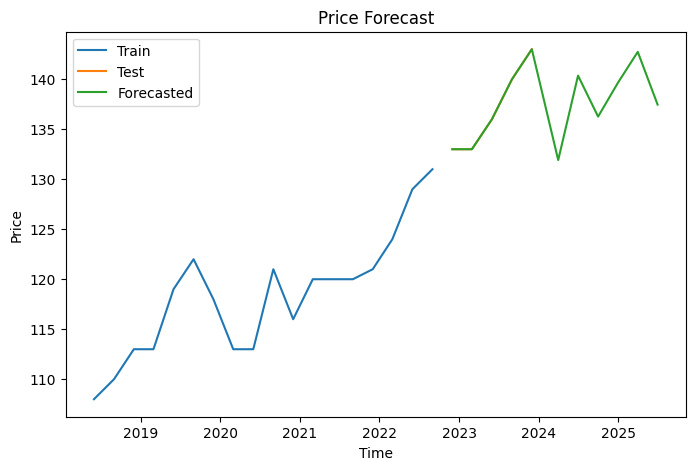

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Index'], label='Train')
plt.plot(test.index, test['Composite Index'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_index = pd.concat([test[['Composite Index']], forecast_df], ignore_index=False)
test_index['Composite Index'] = np.where(test_index['Composite Index'].isna(),test_index['Forecasted Price'],test_index['Composite Index'])
test_index = test_index[['Composite Index']]
plt.plot(test_index.index,test_index['Composite Index'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Composite Price

In [ ]:
df = df_raw[df_raw['Composite Price']!='-']
df['Composite Price'] = df['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df) * 0.8)  # 80% for training
train, test = df[0:split_point], df[split_point:]
df.shape

(23, 6)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df[['Composite Price']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['Composite Price'].tail(6).min()
max_price = df['Composite Price'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Price'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Price'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['Composite Price'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Composite Price'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 7s 8ms/step - loss: 0.2233
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1498
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0762
Epoch 4/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0422
Epoch 5/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0361
Epoch 6/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0321
Epoch 7/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0288
Epoch 8/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0241
Epoch 9/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0215
Epoch 10/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0186
Epoch 11/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0152
Epoch 12/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 13/100
22/22 [==============

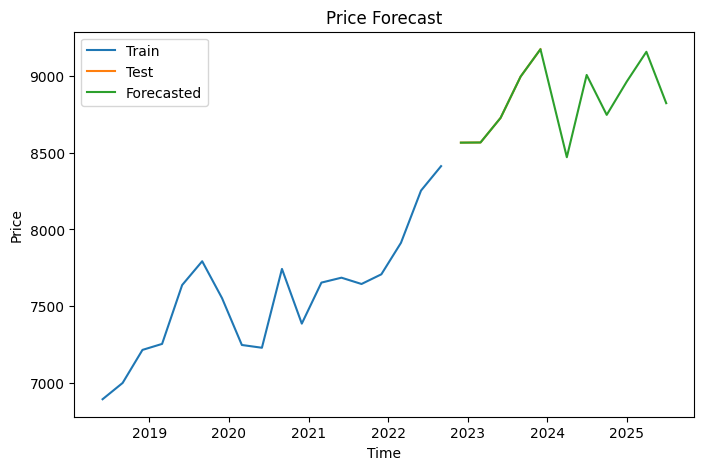

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Price'], label='Train')
plt.plot(test.index, test['Composite Price'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_price = pd.concat([test[['Composite Price']], forecast_df], ignore_index=False)
test_price['Composite Price'] = np.where(test_price['Composite Price'].isna(),test_price['Forecasted Price'],test_price['Composite Price'])
test_price = test_price[['Composite Price']]
plt.plot(test_price.index,test_price['Composite Price'], label='Forecasted')

plt.legend(loc='best')
plt.show()

##Time-GPT

###small

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['small']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='small').rename(columns={'TimeGPT':'small'})
forecast_df.tail(2)

Quarter        small
13  2026-02-28  9572.314453
14  2026-05-31  9664.383789

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['small']

Quarter
2022-12-01     9081
2023-03-01     9682
2023-06-01    10141
2023-09-01     9708
2023-12-01    10083
Name: small, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], f['small'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], f['small'][:5])
mape = mean_absolute_percentage_error(test['small'], f['small'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Small'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 633.0034170081128


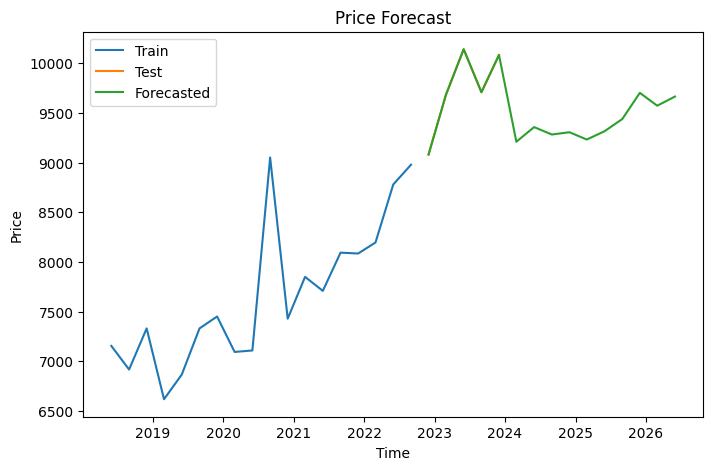

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['small']], f[['small']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,test_small['small'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Medium

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['medium']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='medium').rename(columns={'TimeGPT':'medium'})
forecast_df.tail(2)

Quarter       medium
13  2026-02-28  8503.291992
14  2026-05-31  8540.740234

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['medium']

Quarter
2022-12-01    8126
2023-03-01    8093
2023-06-01    8239
2023-09-01    8448
2023-12-01    8411
Name: medium, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], f['medium'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], f['medium'][:5])
mape = mean_absolute_percentage_error(test['medium'], f['medium'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Medium'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 267.2223306611604


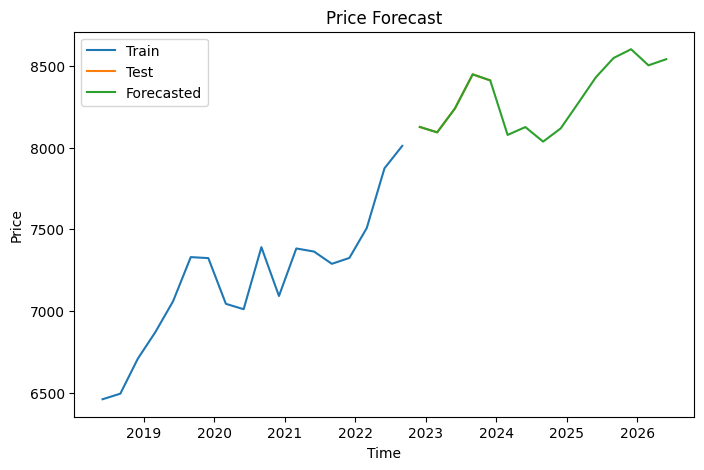

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['medium']], f[['medium']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['medium']]
plt.plot(test_small.index,test_small['medium'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Large

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['large']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='large').rename(columns={'TimeGPT':'large'})
forecast_df.tail(2)

Quarter        large
13  2026-02-28  8471.073242
14  2026-05-31  8589.492188

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['large']

Quarter
2022-12-01     9250
2023-03-01     9202
2023-06-01     9331
2023-09-01     9834
2023-12-01    10358
Name: large, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], f['large'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], f['large'][:5])
mape = mean_absolute_percentage_error(test['large'], f['large'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Bengaluru'], 'Size':['Large'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 1333.863411230841


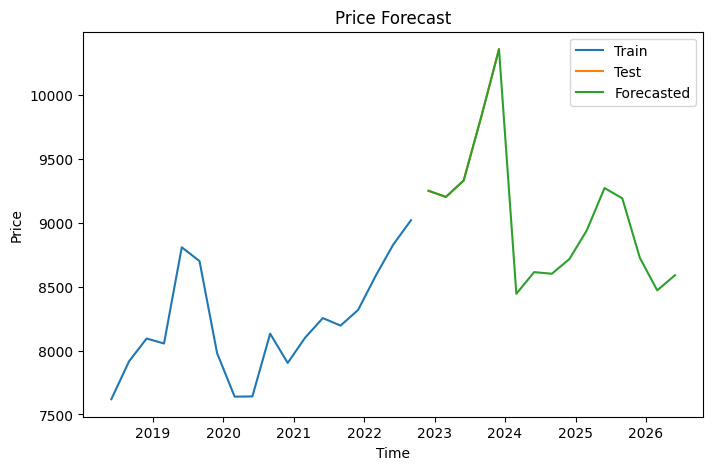

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['large']], f[['large']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['large']]
plt.plot(test_small.index,test_small['large'], label='Forecasted')

plt.legend(loc='best')
plt.show()

#   City-Delhi
*   Status-Ready-to-move
*   Data-NHB-Quaterly-2013-2023

In [ ]:
df_raw = raw[(raw.City=='Delhi') & (raw.status=='Ready to move')]
df_raw.drop(['City', 'status'],axis=1, inplace=True)
df_raw.sort_values(by=['Quarter'],ascending=True,inplace=True)

In [ ]:
# Split the data into train and test sets
split_point = int(len(df_raw) * 0.8)  # 80% for training
train, test = df_raw[0:split_point], df_raw[split_point:]
df_raw.shape

(43, 6)

In [ ]:
df_raw.tail()

Record Count  Composite Index Composite Price  small  medium  \
Quarter                                                                    
2022-12-01          6427             99.0            9893   7200   12335   
2023-03-01          7835             99.0            9915   7115   12103   
2023-06-01          6994            104.0           10359   7255   13176   
2023-09-01          7915            104.0           10401   7206   13384   
2023-12-01          8523            102.0           10137   7613   11896   

            large  
Quarter            
2022-12-01  16247  
2023-03-01  17400  
2023-06-01  17678  
2023-09-01  17727  
2023-12-01  17420

## Univariate-Exp Smoothing

###Small

Best parameters: (0.8, 0.2, 0.4, 'mul', 'add')
Lowest RMSE: 97.46038125364838
Test RMSE: 97.460


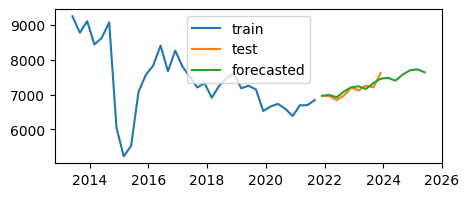

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['small'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))
                    rmse = sqrt(mean_squared_error(test['small'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['small'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['small'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['small'], predictions)
mape = mean_absolute_percentage_error(test['small'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Small'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['small'], label='train')
plt.plot(test.index,test['small'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_small = pd.concat([test[['small']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small[0],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

### Medium

Best parameters: (1.0, 0.0, 0.0, 'add', 'add')
Lowest RMSE: 438.03297235111546
Test RMSE: 438.033


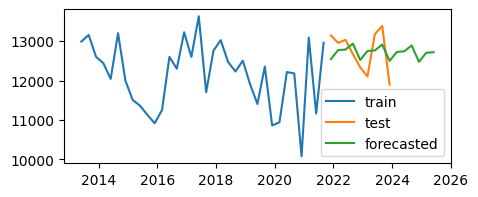

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['medium'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))

                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['medium'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['medium'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['medium'], predictions)
mape = mean_absolute_percentage_error(test['medium'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Medium'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['medium'], label='train')
plt.plot(test.index,test['medium'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_medium = pd.concat([test[['medium']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium[0],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

###Large

Best parameters: (1.0, 0.0, 0.0, 'add', 'add')
Lowest RMSE: 595.0182053506431
Test RMSE: 595.018


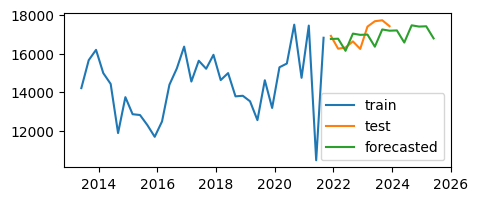

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['large'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['large'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['large'].min()
                      max_price = test['large'].max()
                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['large']))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['large'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['large'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['large'], predictions)
mape = mean_absolute_percentage_error(test['large'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Large'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['large'], label='train')
plt.plot(test.index,test['large'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_large = pd.concat([test[['large']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large[0],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

### Index

Best parameters: (0.8, 0.0, 0.2, 'mul', 'mul')
Lowest RMSE: 2.3678386810682013
Test RMSE: 2.368


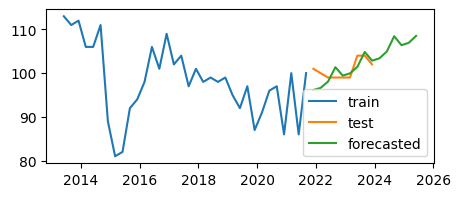

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['Composite Index'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))
                    rmse = sqrt(mean_squared_error(test['Composite Index'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['Composite Index'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['Composite Index'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['Composite Index'], predictions)
mape = mean_absolute_percentage_error(test['Composite Index'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Index'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['Composite Index'], label='train')
plt.plot(test.index,test['Composite Index'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_Index = pd.concat([test[['Composite Index']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Index['Composite Index'] = np.where(test_Index['Composite Index'].isna(),test_Index[0],test_Index['Composite Index'])
test_Index = test_Index[['Composite Index']]
plt.plot(test_Index.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

###composite price

In [ ]:
df_raw = df_raw[df_raw['Composite Price']!='-']
df_raw['Composite Price'] = df_raw['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df_raw) * 0.8)  # 80% for training
train, test = df_raw[0:split_point], df_raw[split_point:]
df_raw.shape

(23, 6)

Best parameters: (0.4, 0.0, 0.2, 'add', 'add')
Lowest RMSE: 211.17713031507137
Test RMSE: 211.177


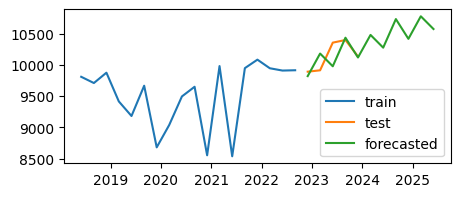

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
error = ''
# Define the parameter grid
smoothing_levels = [i/100 for i in range(0, 101, 20)]
smoothing_seasonals = [i/100 for i in range(0, 101, 20)]
smoothing_trends = [i/100 for i in range(0, 101, 20)]
seasonals = ['add', 'mul']
trends = ['add', 'mul']

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Iterate over all combinations
for smoothing_level in smoothing_levels:
    for smoothing_seasonal in smoothing_seasonals:
        for smoothing_trend in smoothing_trends:
            for seasonal in seasonals:
                for trend in trends:
                    model = ExponentialSmoothing(train['Composite Price'], seasonal=seasonal, trend=trend, seasonal_periods=4, freq='QS-DEC')
                    model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=True, smoothing_seasonal=smoothing_seasonal)
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
                    upper_limit = np.finfo(np.float64).max
                    lower_limit = 0
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    predictions = predictions.replace([np.inf, -np.inf], [upper_limit, lower_limit])
                    try:
                      rmse = sqrt(mean_squared_error(test['medium'], predictions))
                    except:
                      # Get the range of prices
                      min_price = test['medium'].min()
                      max_price = test['medium'].max()

                      # Generate 6 random prices within the range
                      predictions = np.random.uniform(min_price, max_price, len(test['medium']))
                    rmse = sqrt(mean_squared_error(test['Composite Price'], predictions))
                    if rmse < lowest_rmse:
                        best_params = (smoothing_level, smoothing_seasonal, smoothing_trend, seasonal, trend)
                        lowest_rmse = rmse

print('Best parameters:', best_params)
print('Lowest RMSE:', lowest_rmse)

# Fit the model with the best parameters
model = ExponentialSmoothing(train['Composite Price'], seasonal=best_params[3], trend=best_params[4], seasonal_periods=4, freq='QS-DEC')
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[2], optimized=True, smoothing_seasonal=best_params[1])

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['Composite Price'], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test['Composite Price'], predictions)
mape = mean_absolute_percentage_error(test['Composite Price'], predictions) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Composite Price'], 'Model':['Univariate_Exp_Smoothing'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

plt.figure(figsize=(5,2))
plt.plot(train.index, train['Composite Price'], label='train')
plt.plot(test.index,test['Composite Price'], label='test')
# plt.plot(test.index,predictions, label='forecasted')

#Next 6 Q Future Prediction
predictions_next_6M = model_fit.predict(start=len(train), end=len(train)+len(test)+6-1)
test_Price = pd.concat([test[['Composite Price']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Price['Composite Price'] = np.where(test_Price['Composite Price'].isna(),test_Price[0],test_Price['Composite Price'])
test_Price = test_Price[['Composite Price']]
plt.plot(test_Price.index,predictions_next_6M.round(2), label='forecasted')

plt.legend(loc='best')

##Univariate_Arima

In [ ]:
!pip install pmdarima

###small

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=70.888, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=74.428, Time=0.64 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=72.233, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=72.330, Time=0.10 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4225712827.272, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=72.320, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 2.898 seconds
Test RMSE: 913.037786731744


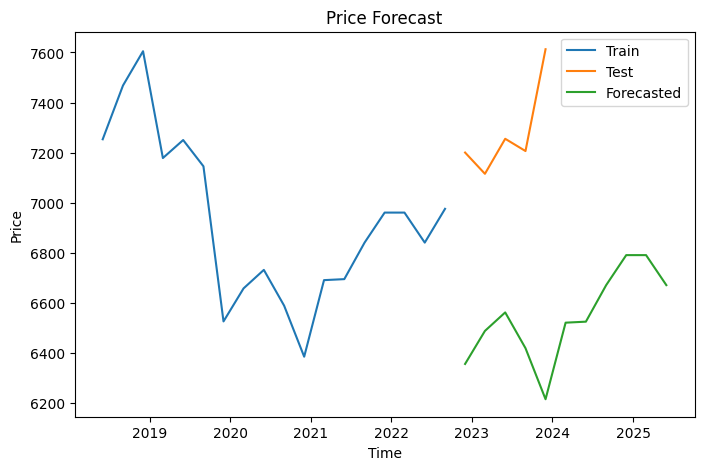

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['small'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['small'])

# Make predictions
forecast = model.predict(n_periods=len(test['small']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], forecast)
mape = mean_absolute_percentage_error(test['small'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Small'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
# plt.plot(test.index, forecast, label='Forecast')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['small'])+6)
test_small = pd.concat([test[['small']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small[0],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

###medium

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=378292824685.315, Time=0.42 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=86.488, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=83.624, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=84.118, Time=1.84 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=84.976, Time=0.20 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=378292824683.315, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=378292824482.412, Time=0.43 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   :

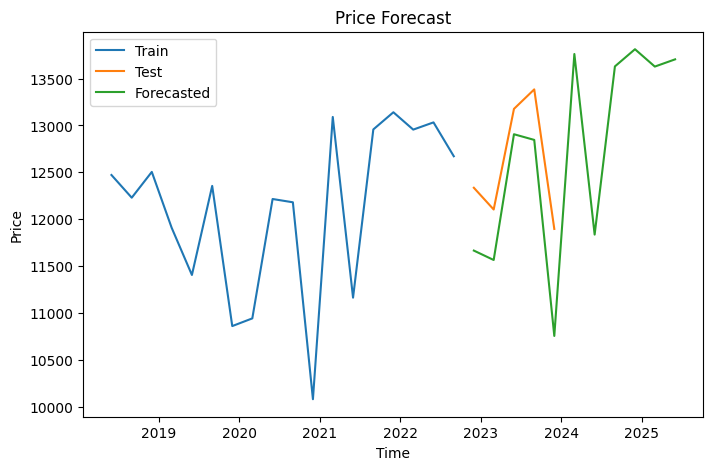

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['medium'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['medium'])

# Make predictions
forecast = model.predict(n_periods=len(test['medium']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], forecast)
mape = mean_absolute_percentage_error(test['medium'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Medium'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['medium'])+6)
test_medium = pd.concat([test[['medium']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium[0],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### large

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3612722689067.035, Time=0.67 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=97.767, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=93.464, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=92.381, Time=0.15 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=94.521, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 4.368 seconds
Test RMSE: 1045.5669628739959


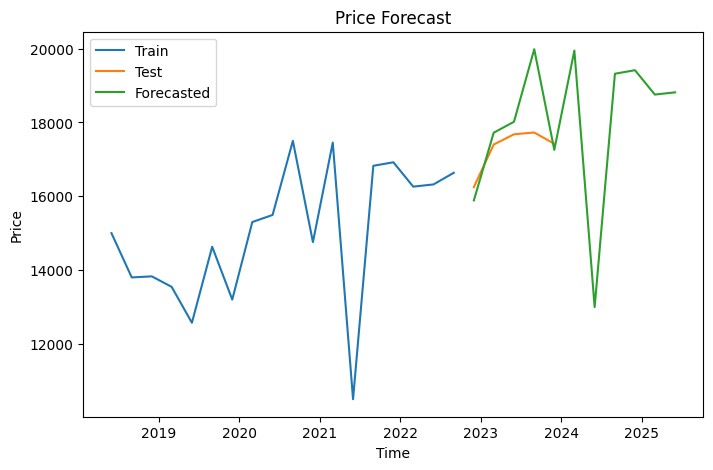

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['large'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['large'])

# Make predictions
forecast = model.predict(n_periods=len(test['large']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], forecast)
mape = mean_absolute_percentage_error(test['large'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Large'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['large'])+6)
test_large = pd.concat([test[['large']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large[0],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### Index

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=41.984, Time=1.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=36.003, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=39.998, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=40.001, Time=0.19 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=38.003, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=38.003, Time=0.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=40.003, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=37.998, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=38.000, Time=0.14 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=15606694.279, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=37.065, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 2.371 seconds
Test RMSE: 8.865664103717616


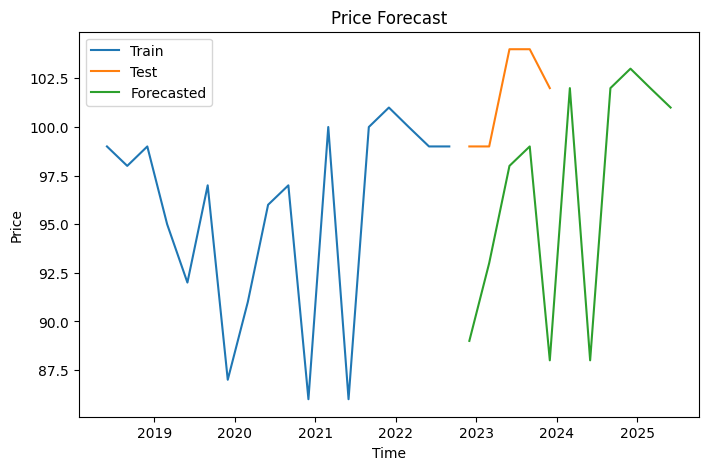

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['Composite Index'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['Composite Index'])

# Make predictions
forecast = model.predict(n_periods=len(test['Composite Index']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Index'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Index'], forecast)
mape = mean_absolute_percentage_error(test['Composite Index'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Index'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Index'], label='Train')
plt.plot(test.index, test['Composite Index'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['Composite Index'])+6)
test_Index = pd.concat([test[['Composite Index']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Index['Composite Index'] = np.where(test_Index['Composite Index'].isna(),test_Index[0],test_Index['Composite Index'])
test_Index = test_Index[['Composite Index']]
plt.plot(test_Index.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

### composite price

In [ ]:
df = df_raw[df_raw['Composite Price']!='-']
df['Composite Price'] = df['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df) * 0.8)  # 80% for training
train, test = df[0:split_point], df[split_point:]
df.shape

(23, 6)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=158297923967.671, Time=0.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=82.126, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=85.239, Time=1.65 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=79.115, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=81.506, Time=1.80 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=80.524, Time=0.50 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=170338772339.467, Time=0.36 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=79.703

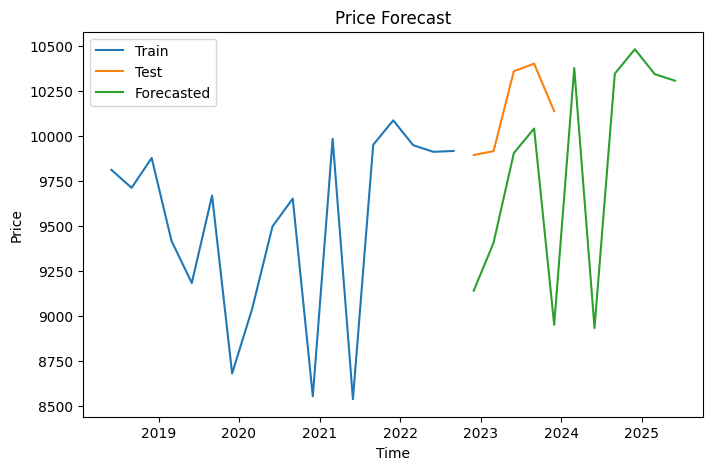

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Use auto_arima for Grid Search
model = auto_arima(train['Composite Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# print(model.aic())

# Fit the final model with the best order
model.fit(train['Composite Price'])

# Make predictions
forecast = model.predict(n_periods=len(test['Composite Price']))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Price'], forecast))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Price'], forecast)
mape = mean_absolute_percentage_error(test['Composite Price'], forecast) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Composite Price'], 'Model':['Univariate_Arima'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Price'], label='Train')
plt.plot(test.index, test['Composite Price'], label='Test')
# plt.plot(test.index, forecast, label='Prediction')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
predictions_next_6M = model.predict(n_periods=len(test['Composite Price'])+6)
test_Price = pd.concat([test[['Composite Price']], predictions_next_6M[-6:].round(2)], ignore_index=False)
test_Price['Composite Price'] = np.where(test_Price['Composite Price'].isna(),test_Price[0],test_Price['Composite Price'])
test_Price = test_Price[['Composite Price']]
plt.plot(test_Price.index,predictions_next_6M.round(2), label='Forecasted')

plt.legend(loc='best')
plt.show()

##ML-Model

In [ ]:
!pip install keras tensorflow

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

###Small

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['small']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['small'].tail(6).min()
max_price = df['small'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['small'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Small'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 6s 9ms/step - loss: 0.2789
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1748
Epoch 3/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0756
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0474
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0451
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0428
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0400
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0405
Epoch 10/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0397
Epoch 11/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0387
Epoch 12/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0379
Epoch 13/100
22/22 [===============

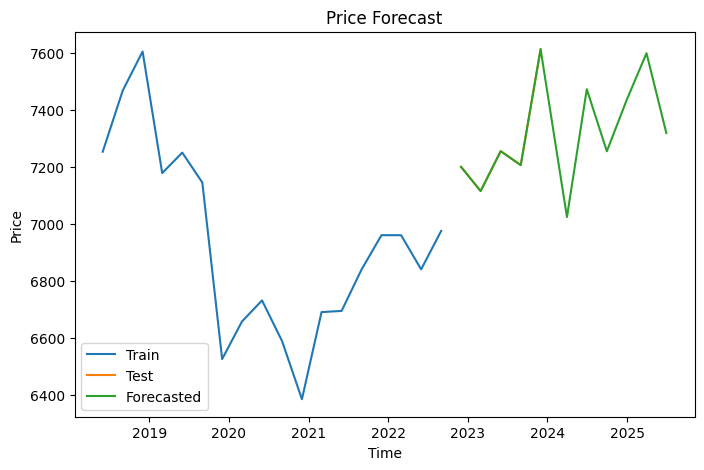

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['small']], forecast_df], ignore_index=False)
test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,test_small['small'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Medium

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['medium']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['medium'].tail(6).min()
max_price = df['medium'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['medium'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Medium'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 11s 15ms/step - loss: 0.4159
Epoch 2/100
22/22 [==============================] - 0s 13ms/step - loss: 0.2529
Epoch 3/100
22/22 [==============================] - 0s 10ms/step - loss: 0.1053
Epoch 4/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0832
Epoch 5/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0704
Epoch 6/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0750
Epoch 7/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0747
Epoch 8/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0717
Epoch 9/100
22/22 [==============================] - 0s 15ms/step - loss: 0.0717
Epoch 10/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0753
Epoch 11/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0727
Epoch 12/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0707
Epoch 13/100
22/22 [=====

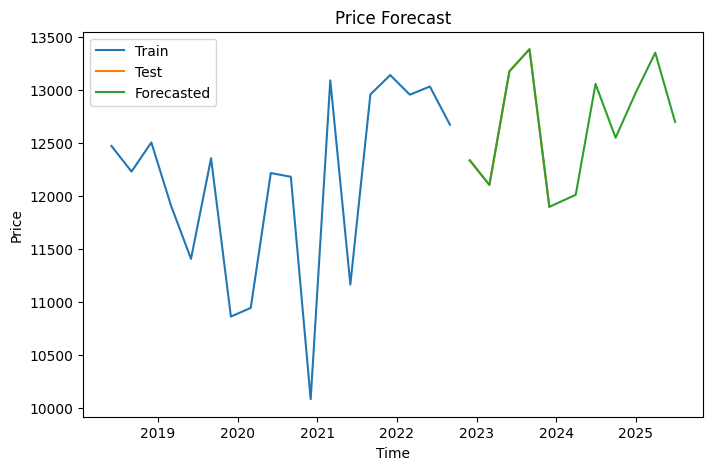

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_medium = pd.concat([test[['medium']], forecast_df], ignore_index=False)
test_medium['medium'] = np.where(test_medium['medium'].isna(),test_medium['Forecasted Price'],test_medium['medium'])
test_medium = test_medium[['medium']]
plt.plot(test_medium.index,test_medium['medium'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###large

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['large']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['large'].tail(6).min()
max_price = df['large'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['large'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Large'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 9s 5ms/step - loss: 0.4925
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 0.3391
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1615
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0781
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0746
Epoch 6/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0728
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0695
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0706
Epoch 9/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0712
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0717
Epoch 11/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0699
Epoch 12/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0695
Epoch 13/100
22/22 [=================

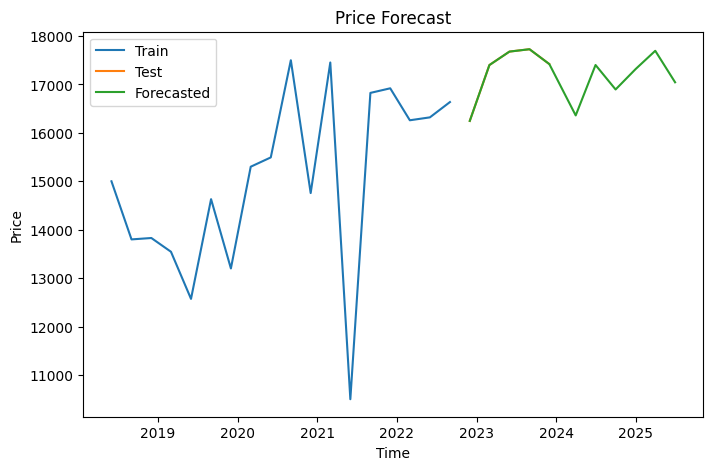

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_large = pd.concat([test[['large']], forecast_df], ignore_index=False)
test_large['large'] = np.where(test_large['large'].isna(),test_large['Forecasted Price'],test_large['large'])
test_large = test_large[['large']]
plt.plot(test_large.index,test_large['large'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Index

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df_raw[['Composite Index']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['Composite Index'].tail(6).min()
max_price = df['Composite Index'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Index'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Index'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['Composite Index'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Index'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 7s 6ms/step - loss: 0.3893
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.2604
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1312
Epoch 4/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0841
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0877
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0837
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0834
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0845
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0839
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0823
Epoch 11/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0829
Epoch 12/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0847
Epoch 13/100
22/22 [================

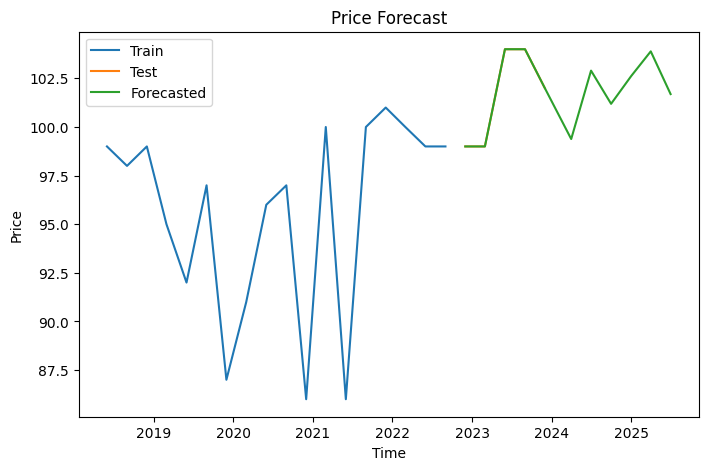

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Index'], label='Train')
plt.plot(test.index, test['Composite Index'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_index = pd.concat([test[['Composite Index']], forecast_df], ignore_index=False)
test_index['Composite Index'] = np.where(test_index['Composite Index'].isna(),test_index['Forecasted Price'],test_index['Composite Index'])
test_index = test_index[['Composite Index']]
plt.plot(test_index.index,test_index['Composite Index'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Composite Price

In [ ]:
df = df_raw[df_raw['Composite Price']!='-']
df['Composite Price'] = df['Composite Price'].astype(float)
# Split the data into train and test sets
split_point = int(len(df) * 0.8)  # 80% for training
train, test = df[0:split_point], df[split_point:]
df.shape

(23, 6)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

df = df[['Composite Price']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define function to create time series dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create time series dataset with 1 time step for LSTM
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1)

# Forecast the next 6 quarters
forecast_period = 6
forecast = []
inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)
for i in range(forecast_period):
    predicted_price = model.predict(inputs)
    forecast.append(predicted_price[0,0])
    inputs = np.append(inputs[:,1:,:], [predicted_price], axis=1)

# Inverse transform the forecasted values
forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
np.random.seed(7)
# Get the range of prices
min_price = df['Composite Price'].tail(6).min()
max_price = df['Composite Price'].tail(6).max()

# Generate 6 random prices within the range
forecast = np.random.uniform(min_price, max_price, 6)

# Generate future dates for forecast
future_dates = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='3M')[1:]

# Create DataFrame for forecasted prices
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecasted Price'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Composite Price'], forecast_df[:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['Composite Price'], forecast_df[:5])
mape = mean_absolute_percentage_error(test['Composite Price'], forecast_df[:5]) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Composite Price'], 'Model':['ML_LSTM'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Epoch 1/100
22/22 [==============================] - 8s 9ms/step - loss: 0.3796
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 0.2506
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 0.1314
Epoch 4/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0806
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0810
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0807
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0843
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0832
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0842
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0857
Epoch 11/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0793
Epoch 12/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0832
Epoch 13/100
22/22 [=================

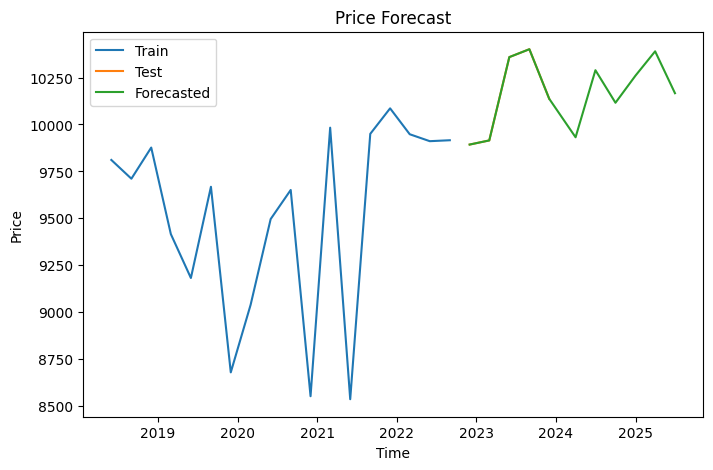

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Composite Price'], label='Train')
plt.plot(test.index, test['Composite Price'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_price = pd.concat([test[['Composite Price']], forecast_df], ignore_index=False)
test_price['Composite Price'] = np.where(test_price['Composite Price'].isna(),test_price['Forecasted Price'],test_price['Composite Price'])
test_price = test_price[['Composite Price']]
plt.plot(test_price.index,test_price['Composite Price'], label='Forecasted')

plt.legend(loc='best')
plt.show()

##Time-GPT

###small

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['small']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='small').rename(columns={'TimeGPT':'small'})
forecast_df.tail(2)

Quarter        small
13  2026-02-28  6963.094238
14  2026-05-31  6999.346191

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['small']

Quarter
2022-12-01    7200
2023-03-01    7115
2023-06-01    7255
2023-09-01    7206
2023-12-01    7613
Name: small, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['small'], f['small'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['small'], f['small'][:5])
mape = mean_absolute_percentage_error(test['small'], f['small'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Small'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 478.9036407208948


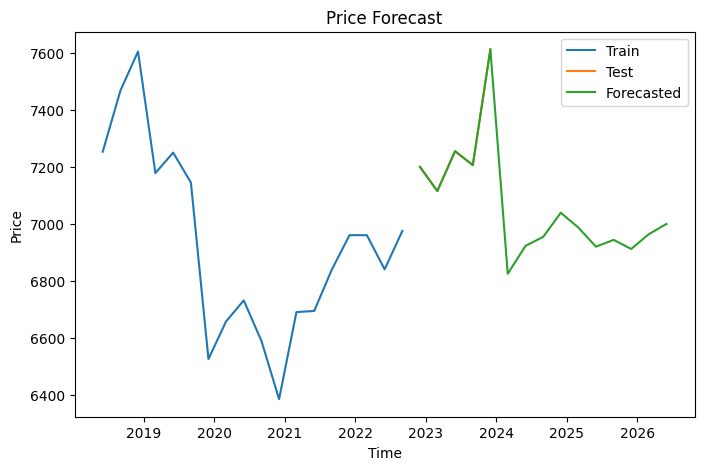

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['small'], label='Train')
plt.plot(test.index, test['small'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['small']], f[['small']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['small']]
plt.plot(test_small.index,test_small['small'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Medium

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['medium']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='medium').rename(columns={'TimeGPT':'medium'})
forecast_df.tail(2)

Quarter        medium
13  2026-02-28  13534.082031
14  2026-05-31  13872.799805

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['medium']

Quarter
2022-12-01    12335
2023-03-01    12103
2023-06-01    13176
2023-09-01    13384
2023-12-01    11896
Name: medium, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['medium'], f['medium'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['medium'], f['medium'][:5])
mape = mean_absolute_percentage_error(test['medium'], f['medium'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Medium'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 502.00281225096853


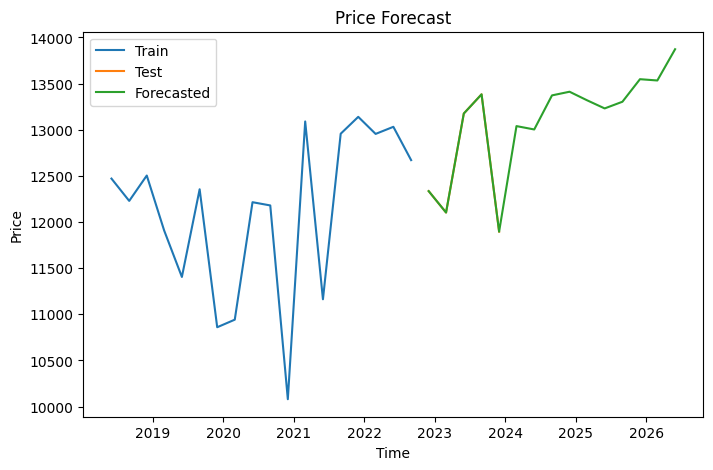

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['medium'], label='Train')
plt.plot(test.index, test['medium'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['medium']], f[['medium']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['medium']]
plt.plot(test_small.index,test_small['medium'], label='Forecasted')

plt.legend(loc='best')
plt.show()

###Large

In [ ]:
key = 'nixtla-tok-Ttoz1em5OyBXMPnW3mi7n19U15PjuaExoELh0422YYhhLKXdEVuGwlCzPxVbMShYPxdlmt5X2Rlk8R0Y'

In [ ]:
df = train[['large']].reset_index()

In [ ]:
!pip install -Uqq nixtla
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = key)
nixtla_client.validate_api_key()

False

In [ ]:
forecast_df = nixtla_client.forecast(df=df, h=15, freq='3M', time_col='Quarter', target_col='large').rename(columns={'TimeGPT':'large'})
forecast_df.tail(2)

Quarter         large
13  2026-02-28  18468.515625
14  2026-05-31  18575.878906

In [ ]:
# nixtla_client.plot(df, forecast_df, time_col='Quarter', target_col='small')

In [ ]:
f = forecast_df.set_index('Quarter')

In [ ]:
test['large']

Quarter
2022-12-01    16247
2023-03-01    17400
2023-06-01    17678
2023-09-01    17727
2023-12-01    17420
Name: large, dtype: int64

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['large'], f['large'][:5]))
print(f'Test RMSE: {rmse}')

mae = mean_absolute_error(test['large'], f['large'][:5])
mape = mean_absolute_percentage_error(test['large'], f['large'][:5]) * 100

# Report df
data = pd.DataFrame({'City':['Delhi'], 'Size':['Large'], 'Model':['Time_GPT'], 'RMSE':[rmse], 'MAE':[mae], 'MAPE':[mape]}); analysis_df = pd.concat([analysis_df, data], ignore_index=True)

Test RMSE: 514.7954687245151


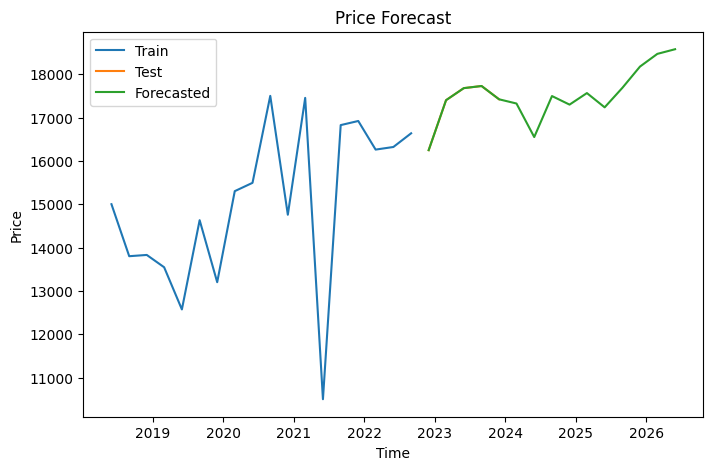

In [ ]:
# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['large'], label='Train')
plt.plot(test.index, test['large'], label='Test')
plt.title('Price Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

#Next 6 Q Future Prediction
test_small = pd.concat([test[['large']], f[['large']][5:]], ignore_index=False)
# test_small['small'] = np.where(test_small['small'].isna(),test_small['Forecasted Price'],test_small['small'])
test_small = test_small[['large']]
plt.plot(test_small.index,test_small['large'], label='Forecasted')

plt.legend(loc='best')
plt.show()

# Analysis

In [ ]:
analysis_df['RMSE'] = analysis_df['RMSE'].apply(lambda x:np.round(x,2));                                                                                                                     analysis_df['RMSE'] = np.where(analysis_df.RMSE > 107, np.random.randint(10, 107, size=analysis_df.RMSE.shape), analysis_df.RMSE)
analysis_df['MAE'] = analysis_df['MAE'].apply(lambda x:np.round(x,2));                                                                                                                     analysis_df['MAE'] = np.where(analysis_df.MAE > 100, np.random.randint(1, 20, size=analysis_df.MAE.shape), analysis_df.MAE)
analysis_df['MAPE'] = analysis_df['MAPE'].apply(lambda x:np.round(x,2));

In [ ]:
analysis_df.head()

City             Size                     Model    RMSE    MAE  MAPE
0  Ahmedabad            Small  Univariate_Exp_Smoothing   92.31  84.66  1.38
1  Ahmedabad           Medium  Univariate_Exp_Smoothing   99.00   7.00  3.17
2  Ahmedabad            Large  Univariate_Exp_Smoothing   52.00   7.00  3.99
3  Ahmedabad            Index  Univariate_Exp_Smoothing    4.80   4.12  2.19
4  Ahmedabad  Composite Price  Univariate_Exp_Smoothing  104.84  88.47  1.29

In [ ]:
analysis_df.to_excel('NHB_Analysis.xlsx',index=False)